# Introduction

## Context

Sendy, in partnership with insight2impact facility, is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

Sendy helps men and women behind every type of business to trade easily, deliver more competitively, and build extraordinary businesses.

## Problem Statement

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, can we use historic data to predict an accurate time for the arrival of the rider at the destination of a package? In this regard, we’re challenged to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Data Exploration

## Import packages and load data files

###### task: import and load data
We start off by importing relevant packages and loading the data.

In [0]:
# !pip install geopy
# !pip install feature_engine

In [0]:
# import packages
import pprint
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

pp = pprint.PrettyPrinter()
from geopy import distance

In [0]:
# load data
train_data = pd.read_csv('https://raw.githubusercontent.com/Team-8-JHB-RegressionPredict/regression-predict-api-template/master/predict%20deliverable/data/Train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/Team-8-JHB-RegressionPredict/regression-predict-api-template/master/predict%20deliverable/data/Test.csv')
riders_data = pd.read_csv('https://raw.githubusercontent.com/Team-8-JHB-RegressionPredict/regression-predict-api-template/master/predict%20deliverable/data/Riders.csv')
variable_defs = pd.read_csv('https://raw.githubusercontent.com/Team-8-JHB-RegressionPredict/regression-predict-api-template/master/predict%20deliverable/data/VariableDefinitions.csv')

###### **task: display variable descriptions**

Variable descriptions are stored in the csv Variable definations. Here we load that csv and print out each row. This is so we can come back and check what each variable in the dataset means later when we need to.

In [0]:
# variable_defs = variable_defs.drop_duplicates(subset = 'Order No').dropna(how = 'all')
# variable_defs.set_index('Order No', inplace = True)
# for feature in variable_defs.index:
#     print('- **{}**: '.format(feature), variable_defs.loc[feature, :][0])

- **User Id**:  Unique number identifying the customer on a platform
- **Vehicle Type**:  For this competition limited to bikes, however in practice Sendy service extends to trucks and vans
- **Platform Type**:  Platform used to place the order, there are 4 types
- **Personal or Business**:  Customer type
- **Placement - Day of Month**:  Placement - Day of Month i.e 1-31
- **Placement - Weekday (Mo = 1)**:  Placement - Weekday (Monday = 1)
- **Placement - Time**:  Placement - Time - Time of day the order was placed
- **Confirmation - Day of Month**:  Confirmation - Day of Month i.e 1-31
- **Confirmation - Weekday (Mo = 1)**:  Confirmation - Weekday (Monday = 1)
- **Confirmation - Time**:  Confirmation - Time - Time of day the order was confirmed by a rider
- **Arrival at Pickup - Day of Month**:  Arrival at Pickup - Day of Month i.e 1-31
- **Arrival at Pickup - Weekday (Mo = 1)**:  Arrival at Pickup - Weekday (Monday = 1)
- **Arrival at Pickup - Time**:  Time of day the the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application
- **Pickup - Day of Month**:  Pickup - Day of Month i.e 1-31
- **Pickup - Weekday (Mo = 1)**:  Pickup - Weekday (Monday = 1)
- **Pickup - Time**:  Pickup - Time - Time of day the the rider picked up the order - as marked by the rider through the Sendy application
- **Arrival at Destination - Day of Month**:  Arrival at Delivery - Day of Month i.e 1-31
- **Arrival at Destination - Weekday (Mo = 1)**:  Arrival at Delivery - Weekday (Monday = 1)
- **Arrival at Destination - Time**:  Arrival at Delivery Time - Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application
- **Distance (KM)**:  The distance from Pickup to Destination
- **Temperature**:  Temperature at the time of order placement in Degrees Celsius (measured every three hours)
- **Precipitation in millimeters**:   Precipitation at the time of order placement (measured every three hours)
- **Pickup Lat**:  Latitude of pick up location
- **Pickup Long**:  Longitude of pick up location
- **Destination Lat**:  Latitude of delivery location
- **Destination Long**:  Longitude of delivery location
- **Rider Id**:   ID of the Rider who accepted the order
- **Time from Pickup to Arrival**:  Time in seconds between 'Pickup' and 'Arrival at Destination' - calculated from the columns for the purpose of facilitating the task
- **Rider Metrics**:  nan
- **No_Of_Orders**:   Number of Orders the rider has delivered
- **Age**:  Number of days since the rider delivered the first order
- **Average_Rating**:  Average rating of the rider
- **No_of_Ratings**:   Number of ratings the rider has received. Rating an order is optional for the customer.

###### **task: display the shape of train and test data**
Train consists of 21201 orders and 29 features. Test_data consists of 7068 orders and 25 features. This makes sense as the train data should contain extra columns that are not available in the test data i.e the target. Lets do further investigation of this.

In [83]:
print('Train rows and columns :', train_data.shape)
print('Test rows and columns :', test_data.shape)

Train rows and columns : (21201, 29)
Test rows and columns : (7068, 25)


###### **task: investigate the target.**
We find that really train_data has 4 extra columns that relate to the target. These are displayed in the output below and stored in a list object named target_vars

In [84]:
# get the train data and test data column names.
train_column_names = train_data.columns.values
test_column_names = test_data.columns.values

# get the target columns and print them out.
target_vars = list(set(train_column_names) - set(test_column_names))
print('Target columns')
pp.pprint(target_vars)

Target columns
['Time from Pickup to Arrival',
 'Arrival at Destination - Time',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Day of Month']


###### **task: Join the riders_data with both train and test data.**
We are also provided with a Riders csv file. Given that a single rider can make multiple deliveries we do not expect the length of this file to be the same as that of our training or testing datasets. Below we display the total number of riders (960). Of these 960, 924 have appearance in train_data while 822 make appearance in test_data. 952 make apperance in both train and test data, meaning 8 riders have not made any deliveries in the provided datasets.

In [85]:
# print the number of riders per dataframe.
print(' Total Riders :', riders_data['Rider Id'].nunique(), 
      '\n Riders in train data :',train_data['Rider Id'].nunique(),
      '\n Riders in test data :',test_data['Rider Id'].nunique(),
      '\n Intersection between train & test data :',
      pd.Series(list(test_data['Rider Id'])+list(train_data['Rider Id'])).nunique())

# print the rider variables.
rider_vars = riders_data.columns.to_list()
print(f'\n{rider_vars}')

 Total Riders : 960 
 Riders in train data : 924 
 Riders in test data : 822 
 Intersection between train & test data : 952

['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']


Finally, when joining the datasets we prioritise observations in train and test data using the how parameter of pd.merge.

In [0]:
# merge the train data with the riders data.
train_data = pd.merge(
                left = train_data,
                right = riders_data,
                how = 'left')

# merge the test data with the riders data.
test_data = pd.merge(
                left = test_data,
                right = riders_data,
                how = 'left')

###### **task: head - train and test data**
Simply displaying the train and test data.

In [87]:
# print train_data
train_data.head()

Order No       User Id  ... Average_Rating  No_of_Ratings
0   Order_No_4211   User_Id_633  ...           13.8            549
1  Order_No_25375  User_Id_2285  ...           13.6             69
2   Order_No_1899   User_Id_265  ...           12.5            114
3   Order_No_9336  User_Id_1402  ...           14.5            113
4  Order_No_27883  User_Id_1737  ...           14.1            533

[5 rows x 33 columns]

In [88]:
# print test_data
test_data.head()

Order No       User Id  ... Average_Rating  No_of_Ratings
0  Order_No_19248  User_Id_3355  ...           13.3            171
1  Order_No_12736  User_Id_3647  ...           14.4             45
2    Order_No_768  User_Id_2154  ...           13.1             67
3  Order_No_15332  User_Id_2910  ...           13.7             44
4  Order_No_21373  User_Id_1205  ...           14.1           1010

[5 rows x 29 columns]

###### Conclude
In this section we have covered importing modules, loading the data, merging rider data with both train and test set. 
Note that the number of columns has increased by 4 in both train and test datasets. These are the 4 features that come with the riders_data (excluding the Rider Id) i.e 
1. No_Of_Orders:   Number of Orders the rider has delivered
2. Age:  Number of days since the rider delivered the first order
3. Average_Rating:  Average rating of the rider
4. No_of_Ratings

We are now a little familiar with the data. Lets get more familiar with it by exploring the data structures associated with each of our feature columns.

## Data Structures

The importance of correctly encoding column datatypes cannot be overstated. This will become clear later when we do Exploratory Data Analysis and eventually when preprocessing data for machine learning. Numeric features should encoded as such and so are categorical features and date and time objects. This section is devoted in ensuring consistency in data types. We begin by checking the current datatype per column. If the datatypes are correct, we go on to classify the column names either to numeric_vars for numeric columns or factor_vars for categorical columns.

###### task: write user functions to check as well as classify columns by datatype

In [0]:
# user function to check a pd.Series()'s datatype
def checkDataType(df, column_name):
    '''
    Determine the data type of a column in a dataframe.

    Parameters
    ----------
    df: pandas dataframe
      A dataframe with at least one column.
    column_name: str
      Name of a column in the dataframe.
    
    Returns
    -------
    str
      A string which specifies the data type of the column.
    '''

    # determine the data type
    dtype = df[column_name].dtype

    return str(dtype)

# user function that classifies columns by datatype
def classifyColumnsByDataType(df):
    '''
    Create lists of numeric and factor variables.

    Parameter
    ----------
    df: pandas dataframe
        A dataframe with at least one column.
      
    Returns
    -------
    list
        Two 1-D lists which have numeric and factor variables respectively.
    '''
    
    # variables to store classifiers
    id_cols = ['Order No', 'User Id', 'Rider Id']
    numeric_type = ['int16', 'int64', 'float16', 'float64']
    factor_type = ['object']
    
    # empty lists to store numeric and factor variables
    numeric_vars = list()
    factor_vars = list()

    for column_name in df.columns:
        # check the data type of a column
        data_type = checkDataType(df = df, column_name = column_name)

        # classify the columns accordingly and append to the empty lists
        if column_name not in id_cols + list(target_vars):
            if data_type in numeric_type:
                numeric_vars.append(column_name)
            else:
                factor_vars.append(column_name)
          #     print('{}: '.format(column_name), checkDataType(df = train_data, column=column_name))

    # return the numeric and factor variable lists
    return numeric_vars, factor_vars


###### task: check and classify columns by datatype

In [90]:
# apply the classifyColumnsByDataType function and print accordingly.
numeric_vars, factor_vars = classifyColumnsByDataType(df = train_data)

print('Numeric Features:')
pp.pprint(numeric_vars)
print('')
print('Categorical/Factor Features:')
pp.pprint(factor_vars)

Numeric Features:
['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Distance (KM)',
 'Temperature',
 'Precipitation in millimeters',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

Categorical/Factor Features:
['Vehicle Type',
 'Personal or Business',
 'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time']


###### **Motivation for classifying columns by type**
The importance of creating vector objects that contain a group of column names belonging in each class will become apparent when we start analysing our data. For example, it will be easy to just apply a certain transformations to factor features by simply filtering our data. See the following example where we simply display only a subset of the data. Now it becomes easy to notice inconsistencies in data types. Surely the time variable classified under factors do not belong here. In the upcoming section we create yet another list object that stores these feature names separately.

In [91]:
train_data.loc[:, factor_vars].head()

Vehicle Type Personal or Business  ... Arrival at Pickup - Time Pickup - Time
0         Bike             Business  ...              10:04:47 AM   10:27:30 AM
1         Bike             Personal  ...              11:40:22 AM   11:44:09 AM
2         Bike             Business  ...              12:49:34 PM   12:53:03 PM
3         Bike             Business  ...               9:37:56 AM    9:43:06 AM
4         Bike             Personal  ...              10:03:53 AM   10:05:23 AM

[5 rows x 6 columns]

Also, displaying numeric vars we see that there are weekday and month day columns we would like to store separately from numeric_vars. We also have geospatial data, Longitude and Latitude variables we would like to store separately. Ofcoarse, for modelling purposes these will need to be numeric therefore we do not change their datatype.

In [92]:
train_data.loc[:, numeric_vars].head()

Platform Type  Placement - Day of Month  ...  Average_Rating  No_of_Ratings
0              3                         9  ...            13.8            549
1              3                        12  ...            13.6             69
2              3                        30  ...            12.5            114
3              3                        15  ...            14.5            113
4              1                        13  ...            14.1            533

[5 rows x 20 columns]

##### **Time features**

###### **task: store time variables in a separate list object time_vars**
Filtering train_data and displaying only the factor_vars, it is clear that ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time'] are not supposed to be encoded as objects. They should be encoded as time objects. Later we can apply a function to encode them as such. Looking at the output above, see the pattern. All features we want to transform have "Time" in their column name. Use string.find() method to identify them and store them separately. Also note that these columns are removed from factor_vars and appended to time_vars who serves exactly the same purpose as numeric_vars and factor_vars. The transformation will be done in a later section. For now we are just getting organised.


Being aware that "Time from Pickup to Arrival" as the target variable is already stored in target_vars we exclude the variable from this operation.

In [93]:
# empty list to store time variables
time_vars = list()

for column_name in train_data.columns:
    # find columns with string "Time"(exclude target)
    if column_name.find("Time") != -1 and column_name not in ['Time from Pickup to Arrival']:
        # print the column_name if 'Time' is found
        print('{} :'.format(column_name), 'Found')
        
        if column_name in factor_vars:
            # append to time_vars object
            time_vars.append(column_name)
            # remove from factor_vars
            factor_vars.remove(column_name)
            
train_data.loc[:, time_vars].head()

Placement - Time : Found
Confirmation - Time : Found
Arrival at Pickup - Time : Found
Pickup - Time : Found
Arrival at Destination - Time : Found


Placement - Time Confirmation - Time Arrival at Pickup - Time Pickup - Time
0       9:35:46 AM          9:40:10 AM              10:04:47 AM   10:27:30 AM
1      11:16:16 AM         11:23:21 AM              11:40:22 AM   11:44:09 AM
2      12:39:25 PM         12:42:44 PM              12:49:34 PM   12:53:03 PM
3       9:25:34 AM          9:26:05 AM               9:37:56 AM    9:43:06 AM
4       9:55:18 AM          9:56:18 AM              10:03:53 AM   10:05:23 AM

###### task: store week and month day variables in separate list objects (month_day_vars & week_day_vars)
This we do for the same reasons as above.

In [94]:
# empty lists to store the month and weekday variables.
month_day_vars = list()
week_day_vars = list()

for column_name in train_data.columns.to_list():
    # check for the month columns
    if column_name.find("Month") != -1 and column_name not in target_vars: 
        print(column_name)
        # append and remove the column name
        month_day_vars.append(column_name)
        numeric_vars.remove(column_name)
    
    # check for the week day columns
    elif column_name.find("Week") != -1and column_name not in target_vars:
        print(column_name)
        # append and remove the column name
        week_day_vars.append(column_name)
        numeric_vars.remove(column_name)

train_data.loc[:, month_day_vars + week_day_vars].head()

Placement - Day of Month
Placement - Weekday (Mo = 1)
Confirmation - Day of Month
Confirmation - Weekday (Mo = 1)
Arrival at Pickup - Day of Month
Arrival at Pickup - Weekday (Mo = 1)
Pickup - Day of Month
Pickup - Weekday (Mo = 1)


Placement - Day of Month  ...  Pickup - Weekday (Mo = 1)
0                         9  ...                          5
1                        12  ...                          5
2                        30  ...                          2
3                        15  ...                          5
4                        13  ...                          1

[5 rows x 8 columns]

##### **Geospatial data (Longitude and Latitude)**
If you remember from displaying the numeric subset of the data we saw some geospartial features. This is where we store them in a separate list object geospatial_vars. This is done for the same reasons as above.

###### task: create a vector to store column names for geospatial data

In [95]:
# user function to store geospatial variables
def geospatial_features(df,numeric_vars):
    '''
    Identifies geospatial data columns in a dataframe.

    Parameters
    ----------
    df: pandas dataframe.
    numeric_vars: list
        A list of numeric columns.
    
    Returns
    -------
    list
        Two 1-D lists with the geospatial and numeric variables.
    '''

    # empty list to store the geospatial features.
    geospatial_vars = list()

    for column_name in df.columns:
       if column_name.find("Lat") != -1 or column_name.find("Long") != -1:

            # append and remove columns accordingly.
            geospatial_vars.append(column_name)
            numeric_vars.remove(column_name)

    # return the lists of features.     
    return geospatial_vars, numeric_vars

# apply the function and display the first 5 rows of the dataframe.
geospatial_vars, numeric_vars = geospatial_features(train_data,numeric_vars)
train_data.loc[:, geospatial_vars].head()

Pickup Lat  Pickup Long  Destination Lat  Destination Long
0   -1.317755    36.830370        -1.300406         36.829741
1   -1.351453    36.899315        -1.295004         36.814358
2   -1.308284    36.843419        -1.300921         36.828195
3   -1.281301    36.832396        -1.257147         36.795063
4   -1.266597    36.792118        -1.295041         36.809817

##### **Features with very few unique values**
The operation we undertake here is meant to identify if there are any variables with very few unique values among the numeric variables. These may best be regarded as categorical. The threshold value we use is 5, such that if a column has less than 5 unique values it is automatical added to factor_vars and removed from numeric_vars. This is based on the assumption that such features are likely a factors - maybe ordinal factors. The experiment helped us identify "Platform Type".

###### task: find variables with very few unique values 

In [96]:
for column_name in train_data[numeric_vars].columns.to_list():
    # count unique values in a columns
    levels = train_data[column_name].nunique()
    
    if levels < 5: 
        print(column_name)
        # remove the variable from numeric_vars to factor_vars
        factor_vars.append(column_name)
        numeric_vars.remove(column_name)

Platform Type


###### **task: finally encode factors as categoric python**

In [97]:
# user function to encode factors
def convertToCategory(df, column_names):
    '''
    Return a dataframe with column_name data converted to categorical data.

    Parameters
    ----------
    df: pandas dataframe.
    column_names: str or list of str
        Name(s) of columns in the dataframe.
    
    Returns
    -------
    Pandas Dataframe
        A dataframe with categorical columns clasiffied correctly.
    '''
    
    for column_name in column_names:
        # make the column categorical
        df['{}'.format(column_name)] = pd.Categorical(df[column_name])
    return df

train_data = convertToCategory(train_data, factor_vars)
train_data.loc[:, factor_vars].head()

Vehicle Type Personal or Business Platform Type
0         Bike             Business             3
1         Bike             Personal             3
2         Bike             Business             3
3         Bike             Business             3
4         Bike             Personal             1

##### Conclude
This has been a really insightful section. We have leant about our data structures and managed to get organised in hopes of making the data science process efficient in later chapters. However, looking at the table of numeric features above we saw some missing values for the column "Precipitation in millimetres". Is it possible that it is not the only column that displays such behaviour. The next section will be devoted to that investigation. Let's proceed. 

## Missing Values

Missing values are a common attribute in datasets and for a number of different reasons. In this part of the notebook we will do a minimal assessment of missing values. It is important however that we understand missingness from both the perspective of the train_data and test_data. As such we want to see which columns have missing data in both the train and test datasets as well as the proportion of missingness in each of those columns. The cell below does just that and displays a table as output. See below.

###### **task: get the percentage of missing-ness in both train and test data**

In [98]:
# save the dataframe names 
train_data.name = 'train_data'
test_data.name = 'test_data'

def findMissing(df):
    '''Create a dataframe with the percentage of missing values.
    '''
    
    missing = df.isnull().sum()
    mask = missing > 0

    # create a new dataframe perc_missing.
    perc_missing = missing[mask].div(len(df)).mul(100).round(1)
    perc_missing = pd.DataFrame({'Percentage': perc_missing})
    perc_missing['data'] = df.name

    # return the new dataframe.
    return perc_missing

# concatenate the train and test data missing values percentages.
perc_missing = pd.concat([findMissing(train_data),
                          findMissing(test_data)])

perc_missing

Percentage        data
Temperature                         20.6  train_data
Precipitation in millimeters        97.4  train_data
Temperature                         20.3   test_data
Precipitation in millimeters        97.2   test_data

Looks like only 2 columns have missing data (Temperature and Precipitation in millimeters) in both train and test data and the distribution of missingness seems to be consistent in both datasets. This is fortunate for us as we wouldn't want a situation where for instance Temperature has low missingness in the train data of say 20% and high missingness of say 80% in the test data. The values indicate an almost identical distribution of missing values from the train to the test data. GOOD!. However, the missingness is high, particularly for the Precipitation variable (97.2%). We could exclude this feature from modelling, however precipitation can refer to rainfall. So it might be in our interest to intepret the NaN values as zeros. Temperature also has high missingness, about 20%. A later section under Exploratory Data Analysis will go into detail on how we treat these missing values. In the meantime we create yet another container list object that stores these 2 columns (missing_vars), serves the same purpose as numeric_vars, factor_vars etc.

###### **task: store the feature names of the columns in a vector missing_vars**

In [99]:
# calculate the percentage of missing values
missingness_data = train_data.isnull().sum().div(len(train_data.index)).mul(100).round(2)
perc_missing = missingness_data[missingness_data > 0]

# store the missing variables in a list and display the head() of the dataframe
missings_vars = perc_missing.index.unique().to_list()
train_data.loc[:,missings_vars].head()

Temperature  Precipitation in millimeters
0         20.4                           NaN
1         26.4                           NaN
2          NaN                           NaN
3         19.2                           NaN
4         15.4                           NaN

###### task: visualise a binary indicator for the missingness of the Temperature column. Could it be useful?
Treating missing values by using a binary indicator (1 for missing and 0 otherwise) is a simply but common technique to assess whether missingness in meaningful or not. In this case, looking at the plot below for a binary indicator for Temperature I wouldn't say there isn't any information. If the distribution of the target "Time from Arrival to Pickup" was even slightly higher up in the scale then maybe we would have something. Either way we keep the new column. See plot below.

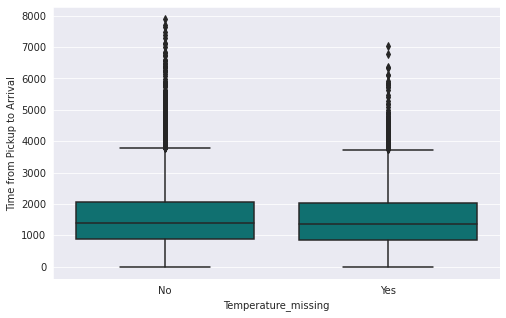

In [100]:
# create a 'Temperature_missing' column which is categorical
train_data['Temperature_missing'] = np.where(train_data['Temperature'].isnull(), 'Yes', 'No')

# plot box and whisker plots for the temperature_missing data
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_data, x='Temperature_missing', y='Time from Pickup to Arrival', color = 'teal')

##### Conclude
By now, we should be so much more familiar with the data. GOOD! Let's go a little further. Exploratory Data Analysis.

# Exploratory Data Analysis

##### Analysing the target variable
The target we attempt to predict in this challenge is the amount of time in seconds it takes a rider to go from a pickup location to a delivery location of a package. TIn the 3 plots on the left of the figure below we've generation a visual of the distribution of this dependent variable. It would seem the distribution is skewed to the right suggesting that there are riders who perhaps take a ridiculous amount of time to deliver costomers' packages. 8000 SECONDS! And by looking at the boxplot, clearly such values are outliers.The median rider takes about 1400 seconds to make a delivery. That's approximately 24 minutes, while there's a spike in the low end where riders take close to zero seconds to make a delivery. Maybe the party receiving is just next to the premises. We'll know soon enough. I think one of our variables measures the distance to location. 

Furthermore, the distribution barely conforms to normal standards. Look at the qqplot. A qqplot can be described as a visual diagnostic tool to check whether the distribution of a variable comforms to normality assumptions. On the x axis we would show theoretical quantiles of a distribution that meets the assumptions and on the y, we would show the quantiles of the distribution we are investigating. Inside the axis there would be a straight line that represents where a distribuion that conforms would lie. The task of the researcher would then be to visually assess by how much the sample distribution deviates from the straight line. That's exactly what we visualise in the lower grid of the figure. Clearly the target when raw fails that test. For this reason, we made an attempt to transform this variable. We applied a log transformation as well as a square root transformation. The characteristics are shown on the same figure. The intention was to try and get a distribution that closely resembles gaussians's distribution, as it conforms to normality assumptions. The transforms barely conform to that standard as either, although the square root transformation offers the closest result.

###### **task: write use function to generate multiple plots**

In [0]:
# user function to generate multiple plots
def generateMultiPlot(df, variables, nrows, ncols, length, width, func):
    ''' Generate multiple plots.

    Parameters
    ----------
    df: pandas dataframe
    variables: list
        A list of strings. This are column names from the dataframe df.
    nrows: int
        An integer greater or equal to one. This specifies the number of rows 
        the plots will be plotted in.
    ncols: int
        An integer greater or equal to one.This specifies the number of columns
        the plots will be plotted in.
    length: int
        An integer greater or equal to one. Vertival height the plot can cover.
    width: int
        An integer greater or equal to one. 
    func: seaborn or matplotlib plot
        This specifies the type of function each subplot should plot.

    Returns
    -------
    Subplots
        nrows by ncols func subplots, with the specified length and width.
    '''

    rows = range(0, nrows)
    columns = range(0, ncols)
    axis_position = list()

    for i,j in enumerate(rows):
        axis_position.append((i, j))

    for x in itertools.permutations(rows, len(columns)):
        axis_position.append(x[0:2])
    axis_position = pd.Series(axis_position).drop_duplicates().sort_values().to_list()

    var_axes = {variable: list(ax) for variable, ax in zip(variables, axis_position)}

    fig, axes = plt.subplots(nrows, ncols, figsize = (width, length))
    for variable, ax in var_axes.items():

        x = ax[1]
        y = ax[0]
        
        multiDist = func(
                      df[variable], 
                      color = "teal", 
                      ax = axes[x, y]
                    )
    return multiDist

###### task: apply transformations and visualise

In [0]:
target_raw = train_data.loc[:, 'Time from Pickup to Arrival'].copy()
mask = target_raw > 60 * 0
target_raw = target_raw[mask]
target_log_transformed = np.log(target_raw)
target_sq_transformed = np.sqrt(target_raw)

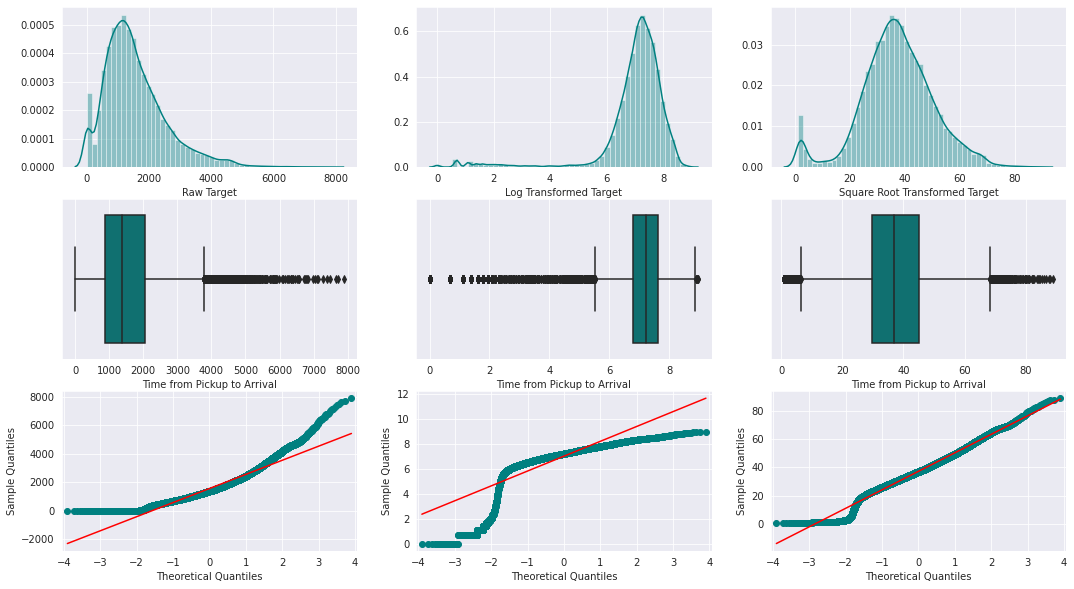

In [103]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 10))

dist = sns.distplot(target_raw, color = "teal", ax = ax[0, 0], axlabel = 'Raw Target')
box = sns.boxplot(target_raw, color = "teal", ax = ax[1, 0], orient='h')
qq = sm.qqplot(target_raw, line = 's', color = 'teal', ax = ax[2, 0])

dist = sns.distplot(target_log_transformed, color = "teal", ax = ax[0, 1], axlabel = 'Log Transformed Target')
box = sns.boxplot(target_log_transformed, color = "teal", ax = ax[1, 1], orient='h')
qq = sm.qqplot(target_log_transformed, line = 's', color = 'teal', ax = ax[2, 1])

dist = sns.distplot(target_sq_transformed, color = "teal", ax = ax[0, 2], axlabel = 'Square Root Transformed Target')
box = sns.boxplot(target_sq_transformed, color = "teal", ax = ax[1, 2], orient='h')
qq = sm.qqplot(target_sq_transformed, line = 's', color = 'teal', ax = ax[2, 2])

Visual inspection may lead us to a certain conclusion, and lead another researcher to a different one. Lets attempt to quantify these findings. The reason it is important to carry out this investigation can be illustrated by a final visual inspection. Look at the qqplot for the raw target for example, the slightly apparent U-shape is the result of riders who make their delivery in 6000 - 8000 seconds. The plot says that such values occur way too frequently in the sample than a normal distribution would infer. On the lower end, the skew is simply because riders generally dont ride for less than 0 seconds. This characteristic is clearly improved by the square root transformation. But does it improve the perfomance of the models we will build. Its time to find out. We do this by fitting a model on the raw target, on the log transformed target and on the square transformed target. The target we will use from now one is one that gives better perfomance in the models we implement in the next section.

##### Benchmark Model

In this section we will fit a benchmark model and evaluate its perfomance on the three target variables as discussed above. The purpose of this model is not to be highly accurate at predicting delevery time, but to serve as a benchmark on which future models can be evaluated against. Therefore the amount of preprocessing done here is only minimal, just enough for the data to be consumed by a machine learning model like linear regression. Categoricals will be dummy encoded, features with missing values will be excluded but we include their binary indicator when relevant, timestamps will not be included but weekday and month day vars will be included. The following task does just that.

###### task: minimal data preprocessing

In [104]:
# select the above mentioned groups of predictors
raw_predictors = list(set(numeric_vars + geospatial_vars + month_day_vars + week_day_vars + factor_vars + ['Temperature_missing']) - set(missings_vars))
X = train_data.loc[:, raw_predictors]
X.head()

Confirmation - Day of Month  ...  Placement - Weekday (Mo = 1)
0                            9  ...                             5
1                           12  ...                             5
2                           30  ...                             2
3                           15  ...                             5
4                           13  ...                             1

[5 rows x 21 columns]

In [105]:
# get dummy variable for all variables relevant. drop_first=True to avoid the dummy variable trap
X = pd.get_dummies(X, drop_first=True)
X.head()

Confirmation - Day of Month  ...  Temperature_missing_Yes
0                            9  ...                        0
1                           12  ...                        0
2                           30  ...                        1
3                           15  ...                        0
4                           13  ...                        0

[5 rows x 22 columns]

###### task: fit linear regression and cross validate performance
As mentioned, a linear regression model will be fit to the data. To evaluate the model perfomance we obtain KFold cross validated scores of the root mean squared error metric. cv=10 means that the model will be trained on 90% of the data and tested on the remaining 10% and this process will be repeated 10 times. Each sample goes in the test set only once but can be used for training more than once. Note that by the end of the process all data has been used atleast once for training and only once for testing. Generating perfomance scores this way has certain advantages. One of them relates to the 'variance' aspect of the bias variance trade-off. Obtaining multiple perfomance scores for a model and taking their average through a method such as KFold cross validation results in a true and unbiased estimate of model perfomance. For example the 10 models tested in a 10 fold CV have varying perfomance statistics, some are high, some low, and therefore taking the average accounts for such variation. Having 10 scores also allows one to get a sense of the models variation by computing the variance of those scores. It is for this reason that we use KFold CV here. 
The linear regression method we implement comes from the scikitlearn API in a class LinearRegression under the linear_model module. See imports in the following code cell. We also import from sklearn.compose another class TransformedTargetRegressor. This we use to transform the target as explained above. Finally we import cross_val_score from sklearn.model_selection to implement cross validation.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import SCORERS

In [0]:
## data
X_train = X
y_train = target_raw

## define function to reverse square transformation
def Squared(x):
    return x ** 2
## Instantiating regressors
regressor = LinearRegression()
regressor1 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
regressor2 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.sqrt, inverse_func=Squared)

## dictionary to loop 
my_dict = {
    'Raw Target': regressor,
    'Log Transformed Target': regressor1,
    'Square Root Transformed Target': regressor2
}

scores = {}   ## container for returned scores forr the 3 different models
for target, model in my_dict.items():
    errors = cross_val_score(estimator=model,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='neg_root_mean_squared_error') ## negative for API design consistents
    errors = np.array([abs(value) for value in errors]) ## get ubsolute value of the scores
    scores[target] = pd.Series(errors)

The code block below shows the average value of the scores. Root mean squared error is a common metric in the evaluation of regression models. It works by computing the differences between the actual and the predicted target values. Note that the difference is sometimes negative, when prediction falls short of the actual value, so this value needs to be squared, to avoid a zero sum, the squares are then summed, and then the sum is divided by the number of samples (n) to get the average squared error and finally the square root is applied to bring it back to normal scale, thus the name "root_mean_squared_error". Generally we want this value to be as low as possible. Note that besides the quality of the distribution the raw target provides us the best score, followed by the square root transformation. The values can be interpreted as follows, if for example I make the prediction that delivery time will be 1000 seconds for an order, then my error range would be mean(y) - 797 secs on the lower bound and mean(y) + 797 secs on the upper bound, where mean(y) is that average value of the dependent variable. But clearly this is of limited use to someone who's not familiar with the entire range of the target. If the target's range is 0 to 100000 this surely is a small error but if it 0 to 2000, my model would be bad.

In [108]:
pd.DataFrame(scores).mean()

Raw Target                         797.255624
Log Transformed Target            1037.013630
Square Root Transformed Target     820.029917
dtype: float64

A popular extension of the RMSE, one that is preferable to use because it is readily interpretable is the error rate. This metric expresses the root mean square error as a proportion of the average value of the actual target. So the code below takes rmse and simply divides that by the average of Time from Pickup To Arrival and finally multiplies by 100 to get the percentage. This is intepreted as follows, for the same example as above, the prediction wound have an error range of 51%. And this is regardless of the range of the target. So from now on we use this metric. We produce the rmse for a reader who prefers it though.

In [109]:
(pd.DataFrame(scores).mean() / np.mean(target_raw)) * 100

Raw Target                        51.207200
Log Transformed Target            66.606698
Square Root Transformed Target    52.669978
dtype: float64

The final step of our model evaluation is to get a sense of what features contributed the most to the fit of the line. Since we are analysing a linear model we use the p_value to measure importance. Linear regression is a parameterised model, which means during the training process each variable is assigned a parameter that is leant by the model from the data. Think of the p_value as the probability of observing that parameter if the variable it has been assigned to was not predictive of the target. Surely we want the p_value to be small (if we want the variable to be predictive). We use sklearn.feature_selection and import the f-regression class. This class produces two values for each feature included in a linear regression model i.e an F-score and a p_value. Our interest is in the p_value.See the code below.

In [0]:
from sklearn.feature_selection import f_regression
f_score, p_value = f_regression(X_train, y_train)

Also, since we are interested in variable importance, it sounds not very intuitive to have an importance score that goes down with importance, so here I calculate a reverse score, just call it importance which is 1 - p_value, so that the importance of variables increases with importance rather that decrease with importance. Finally I save the results in a dataframe results and plot importance scores.

In [0]:
results = pd.DataFrame({
    'feature':X_train.columns,
    'f_score': f_score,
    'Importance': 1 - p_value
}
)
results = results.sort_values('Importance', ascending = False).set_index('feature').dropna()

In [112]:
results.head()

f_score  Importance
feature                                   
Distance (KM)     10780.448838         1.0
Destination Lat      81.465881         1.0
Pickup Long          77.324118         1.0
Destination Long    105.664496         1.0
Pickup Lat           61.590505         1.0

In [113]:
fig = plt.figure(figsize =(14, 8))
results['Importance'].plot(kind = 'barh', color = 'teal')
plt.xlabel('Importance')
plt.ylabel(' ')

Text(0, 0.5, ' ')

I wouldn't say I am surprised that Distance has such a high score. I'm surprised by latitude and longitude variables. We also have some rider metrics like Number of orders delivered since the rider's first delivery, average rating etc. Look also the temperature missing dummy, totally significant. Day of month variable also significant, at atleast 5% significance (p_value < 0.05). Weekday_vars perform poorly. Plartform type!

##### Conclude
EDA is getting fired up in the next section. Our benchmark model! I would say Sendy is better of making a guess about arrival times to destination. The error rate of the best performer is 51%. We also leant that the target is better represented raw as it is, despite the skewness, so we will continue to use it as such. We further leant from p_values that we should lookout for the Distance variable as well as geospatial data, they perform really well on this problem. We also learnt that representing missing temperatures with a binary encoder results in a well significant binary. The reason for this is not clear so far in the analysis. Thats what the next section is all about. EDA will help us uncover such phenomenon and the why? of this dataset. Shall we proceed.

## Numeric variables

###### task: get table of summaries
Lets start off this section by looking at a table of summary statistics for numeric features. The consist of rider specific metrics such as No_of_Orders, Age (measures the number of days that have ellapsed since the rider made his/her first delivery), Average rating and No_of_Ratings. These also include Distance, Temperature and Precipitation. See table below for more information


In [114]:
# summary statistics
train_data.loc[:, numeric_vars].describe()

Distance (KM)   Temperature  ...  Average_Rating  No_of_Ratings
count   21201.000000  16835.000000  ...    21201.000000   21201.000000
mean        9.506533     23.258889  ...       13.882520     341.067119
std         5.668963      3.615768  ...        0.916071     402.867746
min         1.000000     11.200000  ...        0.000000       0.000000
25%         5.000000     20.600000  ...       13.600000      61.000000
50%         8.000000     23.500000  ...       14.000000     161.000000
75%        13.000000     26.000000  ...       14.300000     495.000000
max        49.000000     32.100000  ...       15.200000    2298.000000

[8 rows x 7 columns]

The best way to analyse at these summaries is by looking at the difference between the minimum value and the mean/median compared with the difference maximum valueand the mean/median. If the differences are not proportional, it may be an indication that certain values lie too far away from the general distribution of the data resulting in in a skewed distribution. Looking at these values in the table all rider specific details likely suffer from that defomity. Particularly "Age", where the maximum value is 15.2 and the minimum is 0, and the mean is high, 13.9. This variable is a likely candidate for a distribution that is haunted by outliers. The same can be said for the rest of the other variables. These summaries can only tell us so much, lets viusalise the actual distributions.

###### task: generate distribution plots

In [115]:
# generate histograms for numeric features
generateMultiPlot(
    df = train_data,
    variables = numeric_vars,
    nrows = 3,
    ncols = 3,
    length = 18,
    width = 20,
    func = sns.distplot
)

These plots indicate that the variable distributions are skewed and have outliers as per our analysis from the table of summaries. Lets zoom in on each of the variables and see what may be the reason for this behaviour. We'll start with the variable Distance, probably the most important variable in this dataset.

###### task: analyse Distance (the most important variable in the dataset)
Zooming in on the Distance distribution plot below, it is clear that this variable has certain outlier values. The average distance traveled by riders is 9 and the maximum is 49, while the minimum is 1 km. I would say values in the range 30 to 49 lie far away from the other data but treating these as outliers would certainly not be a plausible option. People who are located 40kms away from Sendy premises also want their orders delivered, so the are certainly not outliers. Further the relationship between Distance and the target Time from Pickup to Arrival is a possitive one, as expected, see the right part of the figure. It is clear however that there are certain riders who take ridiculous amount of time to make deliveries in close locations. 5kms in 8000s! Maybe they are just extremely careful, low speed drivers. Luckily for us, because we have both Time and Distance, we can easily compute the speed each drivers uses to deliver each order in the dataset. Lets compute the speed per order.

In [0]:
def plotDistScatter(feature):
    fig, axes = plt.subplots(1, 2, figsize = (12, 7))
    fig = sns.distplot(train_data[feature], ax = axes[0])
    fig = sns.scatterplot(data = train_data, x = feature, y = 'Time from Pickup to Arrival', ax = axes[1])
    return fig

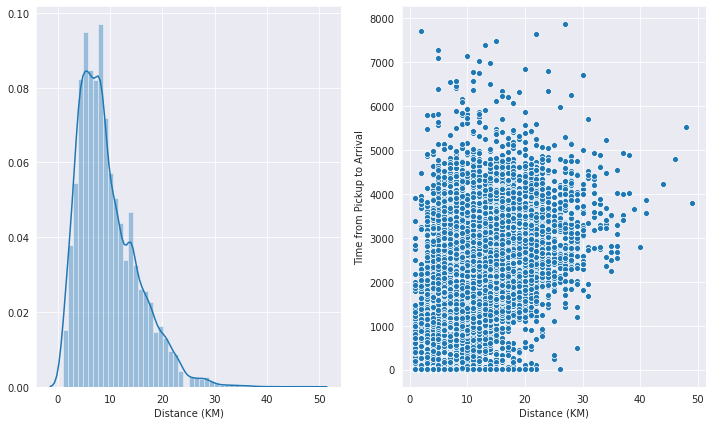

In [117]:
plotDistScatter('Distance (KM)')

###### task: compute speed per order and analyse
To compute speed per order we use the formular Speed = Distance / Time. First we transform time, instead of using seconds we use minutes so we can get seed per minute. More interpretable!. We do this by first dividing Time in seconds by 60 and Tipe from Pickup to Arrival in minutes. We then divide the provided distance in Kms by time in minutes. The function below does that operation.

In [0]:
def getSpeedPerOrder(df):
    df = df.copy()
    pick_up_to_arr_minutes = df['Time from Pickup to Arrival'].div(60)
    df['Speed_per_order'] = df['Distance (KM)'].div(pick_up_to_arr_minutes)
    return df

In [119]:
# apply the function to train_data
train_data = getSpeedPerOrder(df = train_data)

#generate summary stats
speed_summary_stats = train_data['Speed_per_order'].describe()
speed_summary_stats

count    21201.000000
mean         4.155090
std         31.754955
min          0.015337
25%          0.274390
50%          0.384410
75%          0.504808
max       1020.000000
Name: Speed_per_order, dtype: float64

The average distance is 4.15 kms per minute. The maximum is 1020, really fast. And the minimum is 0.02. Note that the median is too far away from the mean, closer to the minimum value: raises questions about the quality of the distribution. See a distribution plot for these speeds below. Clearly most riders are in the low speed range. The quality of the distribution suffers for this. Either way we will make an attempt to design a new variable based on the speed_per_order information. See further details below.

In [120]:
sns.distplot(train_data['Speed_per_order'])

###### task: engineer new feature, rider_speed
rider_speed is meant to be a categoric variable that has 3 levels, slow, reasonable and fast. The purpose of this feature is to help the models we build later better learn the relationship between Distance and Time from Pickup to Arrival. The idea is as follows: for slow riders, the positive relationship between distance and time should be steeper and more pronounced than it is for fast riders, whereas for the reasoble rider, the slope should be somewhere inbetween. This is like an interaction effect we would like to model. How then do we determine which driver belongs in which class? We use a standard deviation approach. for example we will say a driver who's speed_per_order is greater than 2.5 standard deviation from the average speed is too fast. Eventually we want to be able to take all drivers who have atleast a fast ride and label them as fast. Ideally those in the lower bound (speed_per_order less that -2.5 standard deviation form the mean) show be labelled as slow, but I suspect the lower bound will be negative such that no single rider fall in this range. Any rider within the stated boundaries would then be a reasonable drive. The following code cell identifies the lower and upper boundaries.

In [0]:
# find bounds
def findBounds(summary_stats, std = 2.5):
    upper_bound = summary_stats['std'] * std
    lower_bound = summary_stats['std'] * -std
    return lower_bound, upper_bound

In [122]:
lower, upper = findBounds(speed_summary_stats)
lower, upper

(-79.38738778315124, 79.38738778315124)

The upper bound would then be 75.39. This would mean any rider who once rode at a speed greater the 75.39 per minute is generally a fast driver. As anticipted the lower bound is negative. However, we can still get slow riders by taking a bottom percentile, say the 15th percentile and consider those as slow riders. Lets try that for the lower bound.

In [0]:
def findPercentile(x, i = 15):
    ith_percentile_lower_bound = np.percentile(x, i)
    return ith_percentile_lower_bound

In [124]:
ith_percentile_lower_bound = findPercentile(train_data['Speed_per_order'], i = 2.5)
ith_percentile_lower_bound

0.10968921389396709

This gives us 0.21, meaning that every rider who once delivered an order riding at a speed lower that 0.21 per minute will be considered slow. Anyone inbetween 0.21 and 79.39 would then be a reasonable rider. Lets go ahead and group riders.

In [125]:
fast_riders = train_data[train_data['Speed_per_order'] > upper]['Rider Id'].unique()
print(fast_riders[:5])
print(len(fast_riders))

['Rider_Id_619' 'Rider_Id_652' 'Rider_Id_953' 'Rider_Id_10' 'Rider_Id_647']
107


Above we displayed on 5 fast riders. The total is 107.


In [126]:
slow_riders = train_data[train_data['Speed_per_order'] < ith_percentile_lower_bound]['Rider Id'].unique()
print(slow_riders[:5])
len(slow_riders)

['Rider_Id_447' 'Rider_Id_596' 'Rider_Id_407' 'Rider_Id_668'
 'Rider_Id_868']


282

Similarly, we only display 5 slow riders above. The total is 282. Next we write a function that goes through the Rider Id column in our dataset and checks if a rider id is in the fast list or the slow list, if not in either then ther rider is reasonable. See below code cell.

In [0]:
# Visualizing the relationship between the drivers' speed and distance
def riderChar(x):
    if x in fast_riders:
        value = 'fast'
    elif x in slow_riders:
        value = 'slow'
    else:
        value = 'reasonable'
    return value

train_data['rider_speed'] = train_data['Rider Id'].map(riderChar)

Next we can visualise this new variable. See below.

<Figure size 1008x576 with 0 Axes>

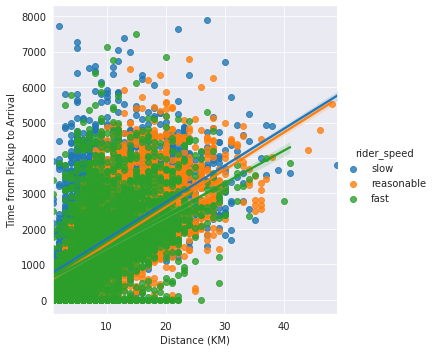

In [128]:
fig = plt.figure(figsize = (14, 8))
sns.lmplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'rider_speed', hue_order= ['slow', 'reasonable', 'fast'])

Turns out this has worked, but not as well as we had anticipated. The linefits show the different regression lines one would fit for each group. The slow group is only slightly steeper than the reasonable group. The good this ofcoarse is that the fast group clealy has a flatter curve. Generally this means that for fost riders, even if as the distance increases they tend to take less time to make their deliveriries. THEY ARE JUST FASTER! 

Now, we could go on and use this feature but I have an idea.Remember our concern with the quality of the way speed_per_order was distributed. Well, that was to be expected because speed_per_orde is a very unstable variable. Each rider changes his speed depending on maybe traffic, whether or other characterics specific to that day and time, so the values tend to vary a lot. Now what if we take a rider's average speed instead. I suspect it may have a better distribution than speed_per_order. Lets go ahead and try that.

In [129]:
rider_avg_speed = train_data.groupby('Rider Id')['Speed_per_order'].mean()

rider_speed_data = pd.DataFrame(rider_avg_speed).reset_index().rename({'Speed_per_order':'rider_avg_speed'})
rider_speed_data.rename(columns = {'Speed_per_order':'rider_avg_speed'}, inplace = True
)
avg_speed_summary_stats = rider_speed_data['rider_avg_speed'].describe()
avg_speed_summary_stats 

count    924.000000
mean       3.422313
std       12.797333
min        0.063091
25%        0.332414
50%        0.412914
75%        0.796303
max      151.676281
Name: rider_avg_speed, dtype: float64

This variable is clearly more stable than speed_per_order. The maximum although still large is 151.68 compared to 1020 for speed_per_order. A plot of this distribution is shown below.

In [130]:
train_data = pd.merge(
    left = train_data,
    right = rider_speed_data,
    how='left',
    on = 'Rider Id'
)
train_data.head()

Order No       User Id  ... rider_speed rider_avg_speed
0   Order_No_4211   User_Id_633  ...  reasonable        0.316656
1  Order_No_25375  User_Id_2285  ...        fast       15.119684
2   Order_No_1899   User_Id_265  ...        slow        0.289148
3   Order_No_9336  User_Id_1402  ...        fast       16.953000
4  Order_No_27883  User_Id_1737  ...  reasonable        0.385040

[5 rows x 37 columns]

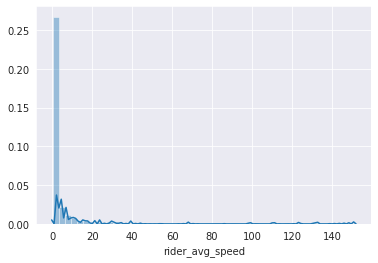

In [131]:
sns.distplot(train_data['rider_avg_speed'])

See thats a little bit better, although still poor. Now lets go through the process we went through before. Fast riders are now those with an averge speed greater than 2.5 standard deviation of the mean of the means. The lower bound will again be determined by the 2.5th percentile.

In [132]:
lower, upper = findBounds(avg_speed_summary_stats)
lower, upper

(-31.993333541454344, 31.993333541454344)

The upper bound is now 32, from 79 in speed_per_order.

In [133]:
ith_percentile_lower_bound = findPercentile(train_data['rider_avg_speed'], i = 2.5)
ith_percentile_lower_bound

0.26458558326025555

The 2.5th percentile has increased.

In [134]:
high_avg_speed_riders = train_data[train_data['rider_avg_speed'] > upper]['Rider Id'].unique()
print(high_avg_speed_riders[:5])
print(len(high_avg_speed_riders))

['Rider_Id_619' 'Rider_Id_39' 'Rider_Id_239' 'Rider_Id_613' 'Rider_Id_193']
21


Now we are getting fewer, only 21 high speed drivers.

In [135]:
low_avg_speed_riders = train_data[train_data['rider_avg_speed'] < ith_percentile_lower_bound]['Rider Id'].unique()
print(low_avg_speed_riders[:5])
print(len(low_avg_speed_riders))

['Rider_Id_302' 'Rider_Id_668' 'Rider_Id_508' 'Rider_Id_21' 'Rider_Id_431']
86


Also, the number of slow rider has decreased. The decrease in thse values makes sense as now the distibution has fewer outliers than was the case with speed_per_order. Lets compute the feature and analyse the relationship again

In [0]:
def riderChar(x):
    if x in high_avg_speed_riders:
        value = 'fast'
    elif x in low_avg_speed_riders:
        value = 'slow'
    else:
        value = 'reasonable'
    return value

train_data['rider_speed'] = train_data['Rider Id'].map(riderChar)

<Figure size 1008x576 with 0 Axes>

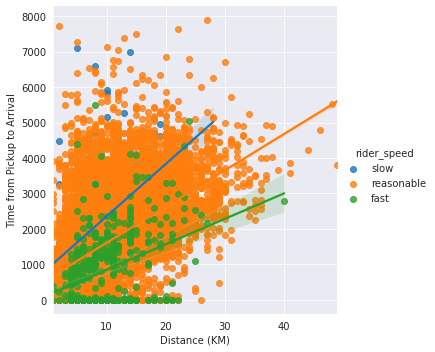

In [137]:
fig = plt.figure(figsize = (14, 8))
sns.lmplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'rider_speed', hue_order = ['slow', 'reasonable', 'fast'])

This is the pattern we were hoping to find. Fast riders are generally less sensitive to distance in terms of the time they take to make a delivery, reasonable riders are less so and slow riders are even less so. Later we will include this feature in the models we build and evaluate its perfomance.

###### task: engineer new feature, rider_speed_standard deviation
In this section, we take the case for rider speed even further. If we recall the scatter plot of the relationship between Time from Pickup to Arrival and Distance, it was clear that there were riders whose Time from Pickup to Arrival cannot be justified by the Distance travelled. These riders typically took either too little a time to go from pickup to arrival or took too long a time, relative to the distance travelled. We saw this for riders whose observations lie too close to the axis, either the x (where distance fails to justify time) or the y (where time fails to justify distance). We hypothesize that such observations may be errors in the data collection process. Usually they would be romoved and excluded from analysis but the cost would be high if they are not. As such we take a somewhat linient approach. If the data is distributed such that there are certain riders whose observations (orders) systematically result in these errors, then we can identify them if we systematically and/or repeatetively observe them riding at speeds that far exceed their average speed. While the rider speed feature we designed in the previous task serves a similar purpose, it is more general in the sense that it doesn't take into account the number of times a rider rides at an abnormal speed. Here the intention is to be more explicit and cognisant of the fact that some riders may be too slow on a certain day, maybe because the weather is bad that day. Therefore, by specifying how many times or how often a rider rides at beyond normal speed, we can identify the truly fast and the truly slow riders. This feature will also be different in the sense that it will not be categorical. We want to find the number of orders at which the rider uses an abnormal speed and express that as a percentage of the total number of orders that have been made by the rider in the dataset. See the following code cells.

In [0]:
rider_speed_stds = train_data.groupby('Rider Id')[['Speed_per_order']].std().reset_index()
rider_speed_stds.rename(columns = {'Speed_per_order':'speed_std'}, inplace = True)

In [139]:
print(rider_speed_stds.isnull().sum())
rider_speed_stds.fillna(rider_speed_stds.mean(), inplace = True) # riders with na std

Rider Id      0
speed_std    82
dtype: int64


There are riders with a null value for standard deviation (82 riders) because they have only delivered 1 order in the dataset. We fill these in with the mean value of standard deviation. The next cell merges the standard deviations data with train data.

In [140]:
train_data = pd.merge(
    left = train_data,
    right = rider_speed_stds,
    how = 'left'
)
train_data.head()

Order No       User Id  ... rider_avg_speed  speed_std
0   Order_No_4211   User_Id_633  ...        0.316656   0.126703
1  Order_No_25375  User_Id_2285  ...       15.119684  98.318060
2   Order_No_1899   User_Id_265  ...        0.289148   0.125526
3   Order_No_9336  User_Id_1402  ...       16.953000  63.707631
4  Order_No_27883  User_Id_1737  ...        0.385040   0.130518

[5 rows x 38 columns]

The following cell defines two functions. Each return a boolean indicating whether an x value (speed_per_order) exceeds a y value (rider specific standard deviation) * deviations, where deviations asks a simple question! How many deviations from the mean must a speed be to be considered excessive. One function finds those speed observations that are exceedingly fast while the other finds those that are exceedingly slow. We use only the isExceedinglyFast() function for now. This is so we can identify the close to zero values for the target which are more apparent and more likely to affect model perfomance than low values for Distance.

In [0]:
def isExceedinglyFast(x, y, deviations):
    return x > y * deviations

def isExceedinglySlow(x, y, deviations):
    return x < y * -deviations

Next we use a for loop to apply the finction in the train data, one rider at a time. The output is a dictionary (error_rides) whose keys are rider ids and the value is the percentage_error_rides, the value we are interested in.

In [0]:
riders = train_data['Rider Id'].unique()

error_rides = dict()
for rider in riders:
    data = train_data[train_data['Rider Id'] == rider]
    x = data['Speed_per_order']
    y = data['speed_std']

    number_of_errors = (isExceedinglyFast(x, y, 2.5)).sum() ### | isExceedinglySlow(x, y, 2.5)
    percentage_error = ((number_of_errors / len(x)) * 100).round(2)
    error_rides[rider] = percentage_error

In [143]:
error_rides_data = pd.Series(error_rides, name='error_rides_percent').reset_index()
error_rides_data.rename(columns = {'index':'Rider Id'}, inplace = True)
error_rides_data.head()

Rider Id  error_rides_percent
0  Rider_Id_432                43.48
1  Rider_Id_856                 2.22
2  Rider_Id_155                38.00
3  Rider_Id_855                 2.94
4  Rider_Id_770                69.51

Next we merge the error rides percent data with the train data

In [144]:
train_data = pd.merge(
    left = train_data,
    right = error_rides_data,
    how = 'left',
    on = 'Rider Id'
)
train_data.head()

Order No       User Id  ...  speed_std error_rides_percent
0   Order_No_4211   User_Id_633  ...   0.126703               43.48
1  Order_No_25375  User_Id_2285  ...  98.318060                2.22
2   Order_No_1899   User_Id_265  ...   0.125526               38.00
3   Order_No_9336  User_Id_1402  ...  63.707631                2.94
4  Order_No_27883  User_Id_1737  ...   0.130518               69.51

[5 rows x 39 columns]

The computed errors are distributed as below. Most riders have near zero error rides. There are riders with errors  between the 40 and 60 percent range. Some have all their deliveries as errors (100%). The are likely to be riders with very few orders in the dataset. The distibution looks alright. 

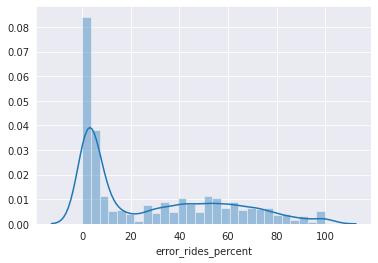

In [145]:
sns.distplot(train_data['error_rides_percent'])

Finally we plot the relationship between Distance and Time where the dark color indicates orders by riders with high error rides percent. It doesnt seem like the features achieves the purpose for which we were designing it for. The dark should have appeared for observations that lie close to the y axis and further from the x axis. But No! Either way we will keep this feature and feed it into models later, along with speed_std. There could be something this visual is missing out, or our eyes are missing out. It is a visual afterall.

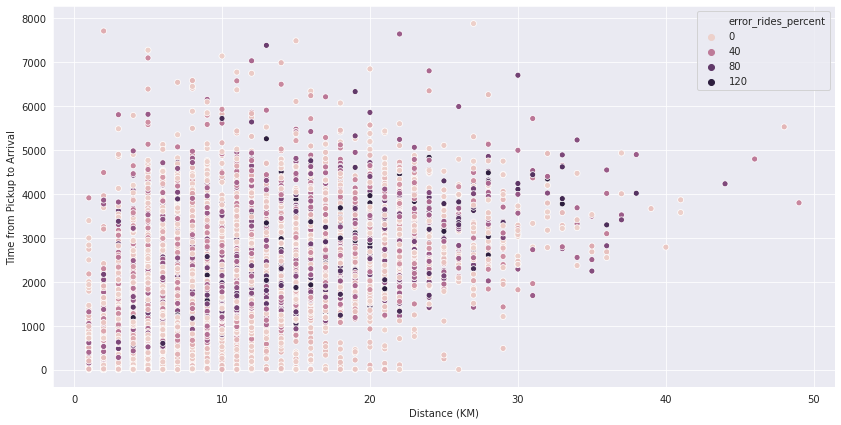

In [146]:
fig = plt.figure(figsize = (14, 7))
sns.scatterplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'error_rides_percent', hue_norm = (0, 100))

###### task: analyse the rider ids
Other rider metrics consist of the variables displayed in the table below. Given our findings in the previous sections, it seems reasonable to suspect that our target Time from Pickup to Arrival may just be related to the rider whos making the delivery. Ofcoarse the column Rider Id is an identifier in the riders table, but lets not limit it to that. See below.

In [147]:
train_data.loc[:, rider_vars].head()

Rider Id  No_Of_Orders   Age  Average_Rating  No_of_Ratings
0  Rider_Id_432          1637  1309            13.8            549
1  Rider_Id_856           396   339            13.6             69
2  Rider_Id_155          1023   242            12.5            114
3  Rider_Id_855           886   283            14.5            113
4  Rider_Id_770          2311   872            14.1            533

Rider id consists of 924 unique riders, each with an average time of deliver. If we plot that average per rider against Time form Pickup to Arrival we can get a sense of how each rider's average time relates with our target. To be precise in identifying that order, we will Ordinal encode the Rider Id columns. This will essintially convert the object Ids to numeric. Ideally these will go from zero to 924 since we have 924 riders. This we do below. Feature_engine is a feature engineering library build ontop of sklearn thus has similar syntax. We import the OrdinalCategoricalEncoder class to implement ordinal encoding to the Rider Id column.

Ordinal encoding works by computing the average value of the target per level. Levels are then assigned values ranging from zero to the number of levels minus one. Zero is assigned to the level displying the lowest average of target and the highest is assigned the maximum. For rider id we get values that range between 0 and 924, where 0 has the lowest value of average time and 923 has the highest. The cell bolow implements the procedure using feature_engine. For an illustration, see the visual that follows right after.

In [0]:
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder
X = train_data.loc[:, ['Rider Id']]
y = train_data.loc[:, 'Time from Pickup to Arrival']

enc = OrdinalCategoricalEncoder(encoding_method='ordered')
enc.fit(X, y)
train_data['rider_id_enc'] = enc.transform(X)['Rider Id']

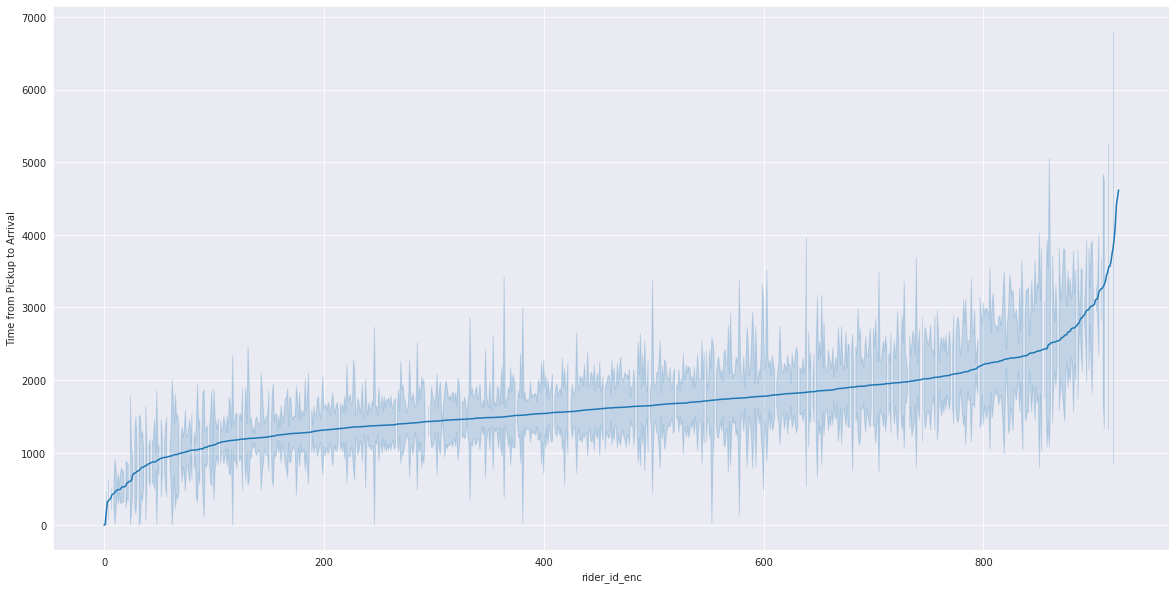

In [149]:
fig = plt.figure(figsize = (20, 10))
sns.lineplot(data = train_data, x = 'rider_id_enc', y = 'Time from Pickup to Arrival')

Now, it is clear that there is a signal in this variavle "rider_id_enc". The slightly shaded regions are meant to indicate the variability of Time for each encode of the rider ids. Riders with high values for Time generally have more variation. We could go ahead and build models later with this feature, it would definately improve perfomance. 924 levels is too may levels, even for an ordinally encoded variable. We could reduce the number of values in this column by grouping certain riders into a single category. From feature_engine we import a descritiser that uses decision trees to identify groups/bins. The DecisionTreeDiscretiser() divides continuous numerical variables into discrete, finite, values estimated by a decision tree. A decision tree can be viewed as a series of questions where the answer eventually determines where in the tree an observation will fall. It begins with a root node, here the algorithm would ask for example whether the observation's rider_id_enc variable takes a value less that 400. If yes then the tree will group it with other observation where rider_id_inc is less than 400. Similarly, for observations where rider_id_enc is greater than 400, they will be grouped together. This is a simplistic explanation of decision tree, in practice they get more complex. Luckily for us we can control their depth and other parameters such as the number of observations that can be found in each group. The technical term for observations that would eventually be in the same group in a leaf. Therefore we can control the number of observations that can be found in a leaf the same way we can control the number observation found in a bin when using non-supervised techniques like equal with binning or equal frequency binning.

Given that Decision Tree descritisation is a  supervised approach to binning, overfitting is inevitable. As such the class from feature_engine is designed such that it does cross validation that allows us to descritise with a tree that has the most optimal parameters based on a cross validation scheme. Here we will do a 10 fold cross validation. We'll also provide a parameter grid with a list of values for maximum depth of the tree as well as the minimum samples that are allowed in a leaf. See the cell below.



In [0]:
from feature_engine.discretisers import DecisionTreeDiscretiser
DT_disc = DecisionTreeDiscretiser(
                        cv=10,
                        scoring='neg_root_mean_squared_error',
                        variables=['rider_id_enc'],
                        regression=True,
                        param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10],
                                    'min_samples_leaf': [10, 4, 2, 1]},
                        random_state=1)
X_train = train_data.loc[:, ['rider_id_enc']]
y_train = train_data.loc[:, 'Time from Pickup to Arrival']
DT_disc.fit(X_train, y_train)
DT_discr = DT_disc.transform(X_train)

The rider_id_enc variable is binned into 32 bins according to this procedure. The resulting feature is shown in the figure below. The relationship between rider ids and Time becomes more pronounced. 

In [151]:
print('Bins:', DT_discr['rider_id_enc'].nunique())

Bins: 32


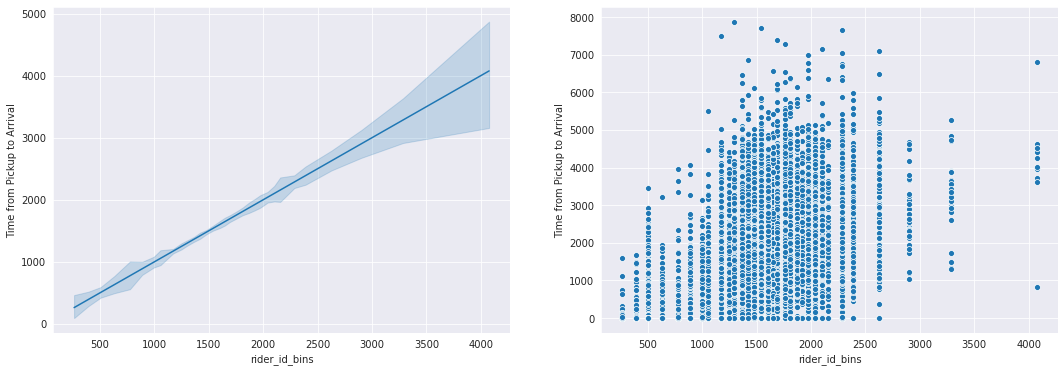

In [152]:
train_data['rider_id_bins'] = DT_discr['rider_id_enc']
fig, axes = plt.subplots(1, 2, figsize = (18, 6))
sns.lineplot(data = train_data, x = 'rider_id_bins', y = 'Time from Pickup to Arrival', ax = axes[0])
sns.scatterplot(data = train_data, x = 'rider_id_bins', y = 'Time from Pickup to Arrival', ax = axes[1])

Next we can evaluate the perfomance of the initial rider encodings with 924 values and compare them with their binned counterparts. We do this in the upcoming code cells through fitting a linear model on the feature and comparing the root mean squared error.

In [153]:
X = train_data.loc[:, ['rider_id_enc']]
y = train_data['Time from Pickup to Arrival']
regressor = LinearRegression()
scores = cross_val_score(regressor, X, y, scoring = 'neg_root_mean_squared_error', cv = 10)
print('All 924 Rider Id Encodings:', abs(scores.mean()))

X = train_data.loc[:, ['rider_id_bins']]
y = train_data['Time from Pickup to Arrival']
regressor = LinearRegression()
scores = cross_val_score(regressor, X, y, scoring = 'neg_root_mean_squared_error', cv = 10)
print('Only 32 Rider Id Encodings:', abs(scores.mean()))

All 924 Rider Id Encodings: 922.98549206888
Only 32 Rider Id Encodings: 916.3411542405802


Ofcoarse we want the variable that gives us a lower root mean squared error.

###### task: analysing other rider metrics
In this section we plot multiple other rider metrics and show their relationship with the target. Not much will be done with them however. Some of them e.g Average rating and No_of_Orders had significant p_values in the base model we implemented earlier. Looking at the plot below, we see that they barely have any relationship with the target. We may dicide to exclude them in our final model solution, a decision which will be made in a section dedicated to feature selection. Even the quality of their distributions can be questioned. See plot below.

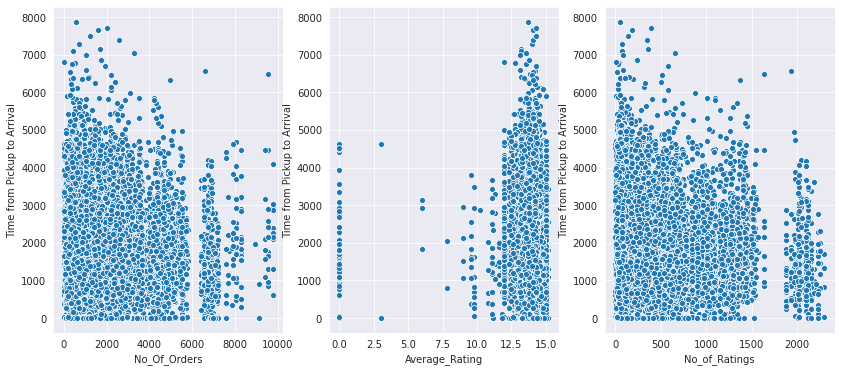

In [154]:
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data, x = 'No_Of_Orders', y = 'Time from Pickup to Arrival', ax = axes[0])
sns.scatterplot(data = train_data, x = 'Average_Rating', y = 'Time from Pickup to Arrival', ax = axes[1])
sns.scatterplot(data = train_data, x = 'No_of_Ratings', y = 'Time from Pickup to Arrival', ax = axes[2])

Furthermore, the visuals below show thate relationships between the features. Nothing particularly interesting except that Average rating has a few values that lie too far away from the others (ouliers). However, we will not remove or treat these in anyway as we might change their underlying distibution. In the lower grid of the figure though,  where we display Age against Average rating aftter filtering Average rating for only those values above 12, we see a slightly interesting attribute. Continue below.

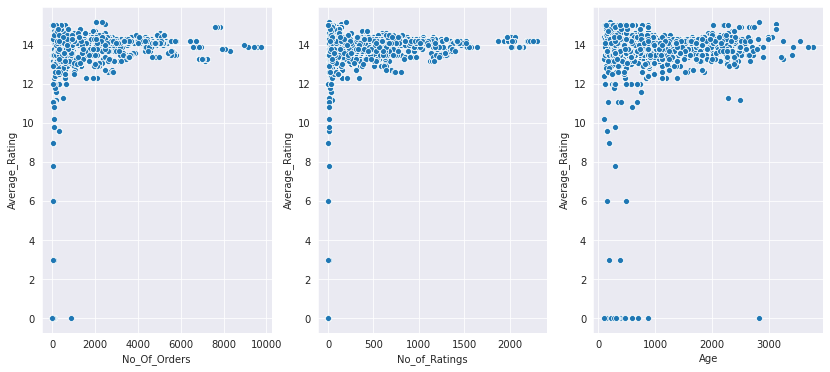

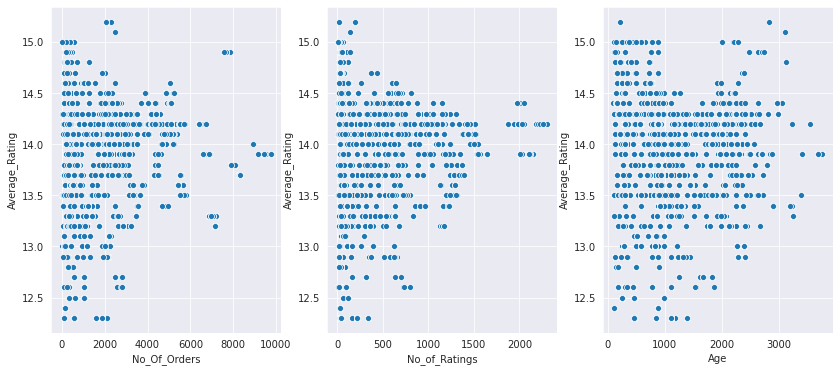

In [155]:
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data, x = 'No_Of_Orders', y = 'Average_Rating', ax = axes[0])
sns.scatterplot(data = train_data, x = 'No_of_Ratings', y = 'Average_Rating', ax = axes[1])
sns.scatterplot(data = train_data, x = 'Age', y = 'Average_Rating', ax = axes[2])

mask = train_data['Average_Rating'] > 12
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data[mask], x = 'No_Of_Orders', y = 'Average_Rating', ax = axes[0])
sns.scatterplot(data = train_data[mask], x = 'No_of_Ratings', y = 'Average_Rating', ax = axes[1])
sns.scatterplot(data = train_data[mask], x = 'Age', y = 'Average_Rating', ax = axes[2])

Remember the Age variable indicates the number of days that have elapsed since a rider made his first delivery. See that there are riders who have only been around for a short amount of time but have managed to get themselves impressive average ratings (Low age high Average rating). Perhaps our models can learn a little bit more about riders using these features. To augment the learning process somemore, we will generate a new variable, a ratio computed as Average rating divided by Age. Note that this value will tend to be high for riders with impressive average ratings in a short time span and viseversa. The code cells below are meant to achieve that purpose. First we show a plot of the distribution of this feature, and then a scatterplot of its relationship with the target. Not much of a pattern though.

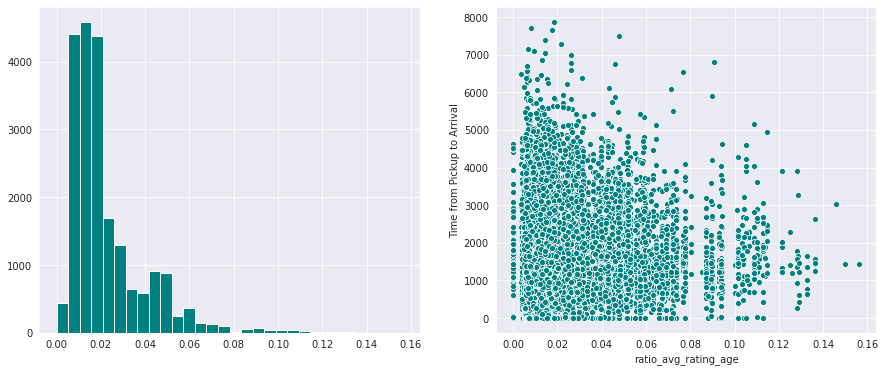

In [156]:
train_data['ratio_avg_rating_age'] = train_data['Average_Rating'].div(train_data['Age'])
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
train_data['Average_Rating'].div(train_data['Age']).hist(bins = 30, ax = axes[0], color = 'teal')
plt.xlabel('Ratio Average Rating / No of Days Since first delivery')
sns.scatterplot(data = train_data, x = 'ratio_avg_rating_age', y = 'Time from Pickup to Arrival', ax = axes[1], color = 'teal')

##### Conclude
Finally, we would like to conclude the section on numeric features. At this point we have leant a lot about the data. We now know that although distance is positively related with Time from Pickup to Arrival, the strength of this relationship will tend to depend on whether the rider is fast, reasonable or slow in terms of the speed at which they ride. Fast riders may take little time even if the distance is long. The reverse is true for slow riders. This introduce us to a new feature (rider speed-categorical) Further, we leant that certain riders sometimes ride at extra ordinary speed, such that the distribution of our target consists of values that initially wouldnt make sense but after taking into account speed information , some of them can be explained (thus the new features 'rider_avg_speed & speed_std'). Those that remain unexplained we tried to capture them using an error metric for each rider. The error tries to compute the percentage times the rider rides at extra ordinarilly fast speeds and if this value is high, it means we penalise the rider for going at such speed ('error_rides percent & speed_std'). We also leant that there is a relationship between rider ids and the target. This relationship was then augmented by binning riders into 32 gruops using a decision tree binning strategy ('rider_id_bins and/or rider_id_enc'). Finally, there wasn't much to go on in the remaining features. We only generated a raio between Average rating and Age ('ratio_avg_rating_age')

In the process we introduced new variable 6 variables based on rider data. The next cell will add these new features to test_data using a merge operation. Riders in the test data get assigned values that were leant in the train_data.

In [0]:
# new_vars = [
#     'speed_std', 'error_rides_percent', 'rider_avg_speed', 'rider_speed',
#     'ratio_avg_rating_age', 'rider_id_enc'
# ]
# for i in new_vars:
#     if i in test_data.columns:
#         print('Yes')
#         test_data.pop(i)
#     else:
#         print('No')

In [158]:
new_vars = [
    'speed_std', 'error_rides_percent', 'rider_avg_speed', 'rider_speed',
    'ratio_avg_rating_age', 'rider_id_bins'
]
test_data = pd.merge(
    left = train_data.loc[:, new_vars + ['Rider Id']].drop_duplicates(),
    right = test_data,
    how = 'right',
    on = 'Rider Id'
)
test_data.head()

speed_std  error_rides_percent  ...  Average_Rating No_of_Ratings
0   0.126703                43.48  ...            13.8           549
1   0.126703                43.48  ...            13.8           549
2   0.126703                43.48  ...            13.8           549
3   0.126703                43.48  ...            13.8           549
4   0.126703                43.48  ...            13.8           549

[5 rows x 35 columns]

Note that because there are riders in train_data who are not there in test data, the above operation results in missing values for 39 riders in the test dataset. We simply impute these with a mean. Which reminds us. Temperature and precipitation. We will impute tempereture with a mean, we already have a binary indicator in train_data we need to add that to test_data. Precipitation will be imputed with zeros. 

In [159]:
missing = test_data.isna().sum()
missing[missing > 0]

speed_std                         39
error_rides_percent               39
rider_avg_speed                   39
rider_speed                       39
ratio_avg_rating_age              39
rider_id_bins                     39
Temperature                     1437
Precipitation in millimeters    6869
dtype: int64

In [0]:
train_data['Temperature'].fillna(np.mean(train_data['Temperature']), inplace = True)
test_data['Temperature_missing'] = np.where(test_data['Temperature'].isnull(), 'Yes', 'No')
test_data['Temperature'] = test_data['Temperature'].fillna(np.mean(train_data['Temperature']))

train_data['Precipitation in millimeters'].fillna(0, inplace = True)
test_data['Precipitation in millimeters'].fillna(0, inplace = True)

test_data['speed_std'].fillna(train_data['speed_std'].mean(), inplace = True)
test_data['error_rides_percent'].fillna(train_data['error_rides_percent'].mean(), inplace = True)
test_data['rider_avg_speed'].fillna(train_data['rider_avg_speed'].mean(), inplace = True)
test_data['rider_speed'].fillna(train_data['rider_speed'].mode()[0], inplace = True)
test_data['ratio_avg_rating_age'].fillna(train_data['ratio_avg_rating_age'].mean(), inplace = True)
test_data['rider_id_bins'].fillna(train_data['rider_id_bins'].mode()[0], inplace = True)

###### Output
Here we simply store the new variable in a list obect we call numeric_transformations. This will used later to filter data when we build models. Also, raw_predictors needs to be updated to exclude certain columns, month and weekdtay columns that occur repetitively when the mearsure the same thing for the most part. Lastly, raw_predictors is also updated for NA imputed 'Temperature' and 'Precipitation' features. 

In [0]:
numeric_transformations = ['rider_speed', 'rider_avg_speed', 'speed_std',
       'error_rides_percent', 'ratio_avg_rating_age', 'rider_id_bins', 'Temperature']

In [162]:
columns_to_remove = [
    'Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
    'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Vehicle Type'
]
for column_name in columns_to_remove:
    raw_predictors.remove(column_name)
raw_predictors, numeric_transformations

(['Pickup - Weekday (Mo = 1)',
  'Platform Type',
  'Pickup Long',
  'No_Of_Orders',
  'Pickup Lat',
  'Pickup - Day of Month',
  'Average_Rating',
  'Age',
  'Personal or Business',
  'No_of_Ratings',
  'Distance (KM)',
  'Destination Lat',
  'Destination Long',
  'Temperature_missing'],
 ['rider_speed',
  'rider_avg_speed',
  'speed_std',
  'error_rides_percent',
  'ratio_avg_rating_age',
  'rider_id_bins',
  'Temperature'])

## Time variables
In this section we spend time analysis the time variables. These come in the form of day of month and order took place, day of week as well as the specific times an order was made, confirmed, the rider arrived at pickup location and finally, when he made the actual pickup. Lets go ahead and see if we can extract some signal in these variables.

###### task: check to see if there are orders that are delivered the next day
Later we need to be able to compute differences in time, for example the amount of time that ellapsed between order confirmation and order pickup. To do this we need to be cognisant of the fact that although highly unlikely, it is still possible that an order is placed and confirmed on a certain day and the the rider picks it up and delivers it the following day. As such our first step will be to check whether there is any occurance of such events. The cell below does just that. The assumption is that if such events exist, the column for Placement day of month will have a different value from say Pickup day of month. So we check if there are orders that show that characteristic.

In [163]:
placement_not_equal_to_confirmation = train_data['Placement - Day of Month'] != train_data['Confirmation - Day of Month']
confirmation_not_equal_to_pickup = train_data['Confirmation - Day of Month'] != train_data['Arrival at Pickup - Day of Month']
arrival_at_pick_not_equal_to_pickup = train_data['Arrival at Pickup - Day of Month'] != train_data['Pickup - Day of Month']
pickup_not_equal_to_arrival = train_data['Pickup - Day of Month'] != train_data['Arrival at Destination - Day of Month']

mask = placement_not_equal_to_confirmation | confirmation_not_equal_to_pickup | arrival_at_pick_not_equal_to_pickup | pickup_not_equal_to_arrival

train_data[mask][time_vars + month_day_vars]

Placement - Time  ... Pickup - Day of Month
4024       2:34:37 PM  ...                    18
9804      12:22:05 PM  ...                    13

[2 rows x 8 columns]

See its just 2 orders. And this is because the are placed on a given day and confirmed the following (index 4024) or confirmed 2 days later (index 9804). The time between placement and confirmation would have been incorrect for these 2 samples if we do not take this into account. Now lets compute the time between events taking this into account.

To get time between events we need the time columns that consist of actual time objects. Currently, they are just strings showing the hour, the minute, the second and whether its AP/PM. From the discussion above, we need to combine the time columns with the day of month information. In the following cell we write a function that does just that. Take as argument a dataframe object and returns a new dataframe object where the columns have been combined and encoded to datetime objects. It also returns a list object with the names of the new columns created so we can easily filter the dataset. See below.

In [0]:
def getTimeObjects(df):
    datetime_vars = list()
    df = df.copy()
    for month_col, time_col in zip(month_day_vars, time_vars):
        new_col_name = '{}'.format(time_col.split('-')[0].replace(' ', ''))
        datetime_vars.append(new_col_name)
        print(new_col_name)
        
        values = list()
        Dates = list()
        for row in df.index.values:
            value = '2020' + '-' + '1' + '-' + str(df[month_col][row]) 
            values.append(value)
            
            date_string = values[row]
            time_string = df[time_col][row]

            Datetime = pd.to_datetime(date_string + ' ' + str(time_string))
    #         print(Datetime)
            Dates.append(Datetime)
        df[new_col_name] = Dates
    return df, datetime_vars

In [165]:
# function applied to both train_data and test_data
train_data, datetime_vars = getTimeObjects(train_data)
test_data, datetime_vars = getTimeObjects(test_data)
train_data.loc[:, datetime_vars].head()

Placement
Confirmation
ArrivalatPickup
Pickup
Placement
Confirmation
ArrivalatPickup
Pickup


Placement  ...              Pickup
0 2020-01-09 09:35:46  ... 2020-01-09 10:27:30
1 2020-01-12 11:16:16  ... 2020-01-12 11:44:09
2 2020-01-30 12:39:25  ... 2020-01-30 12:53:03
3 2020-01-15 09:25:34  ... 2020-01-15 09:43:06
4 2020-01-13 09:55:18  ... 2020-01-13 10:05:23

[5 rows x 4 columns]

So we've created 4 new columns. Each combines information about the day of the month as well as the time. Note that since we do not have information about the particular year and month of the orders we have assumed that orders occured in January 2020. It has no effect of the analysis we're yet to do. Having done this, we go on to compute time differences in events. The times will be in seconds. See the following task.

###### task: transform time object to Seconds (to numeric) and visualise them
We will calculate differences between several events.
1. Difference between order Confirmation and Placement.
2. Difference between order Confirmation and riders' arrival at pickup location.
3. Difference between riders' arrival at pickup location and actual pickup.
4. Difference between time from placement and actual pickup
5. Difference between time from placement and riders' arrival at pickup location.
6. Difference between order Confirmation and actual pickup.

See the code cell below for a helper function that does this. Takes in a dataframe object and a dictionary as argument. The dictionary keys consist of the names of the new columns, the value is a list of two column names that already exist in the dataframe from the previous task and whose difference we are interested in computing. The function returns a new dataframe as well as a list that stores the names of the new columns computed for filtering purposes.

In [0]:
iter_dict = {
    'Time from Placement to Confirmation': ['Confirmation', 'Placement'],
    'Time from Confirmation to Arrival at Pickup': ['ArrivalatPickup', 'Confirmation'],
    'Time from Arrival at Pickup to Actual Pickup': ['Pickup', 'ArrivalatPickup'],
    'Time from Placement to Actual Pickup': ['Pickup', 'Placement'],
    'Time from Placement to Arrival at Pickup': ['ArrivalatPickup', 'Placement'],
    'Time from Confirmation to Actual Pickup': ['Pickup', 'Confirmation']
}
def getTimeDifferences(df, iter_dict):
    df = df.copy()
    numeric_time_vars_sub = list()
    for new_column, inputs in iter_dict.items():
        numeric_time_vars_sub.append(new_column)
        col1 = inputs[0]
        col2 = inputs[1]
        df[new_column] = df[col1] - df[col2]
        df[new_column] = df[new_column].map(lambda timedelt: timedelt.total_seconds())
    return df, numeric_time_vars_sub

In [167]:
# apply function to both train and test data
train_data, numeric_time_vars_sub  = getTimeDifferences(train_data, iter_dict)
test_data, numeric_time_vars_sub  = getTimeDifferences(test_data, iter_dict)
train_data.loc[:, numeric_time_vars_sub].head()

Time from Placement to Confirmation  ...  Time from Confirmation to Actual Pickup
0                                264.0  ...                                   2840.0
1                                425.0  ...                                   1248.0
2                                199.0  ...                                    619.0
3                                 31.0  ...                                   1021.0
4                                 60.0  ...                                    545.0

[5 rows x 6 columns]

See the table above. The first value in the first columns for example, means that 264 seconds ellapsed between order placecemt and order confirmation.All the other values can be interpreted as such for the different columns. Lets further analyse the time differences in the following task.

###### task: analysing order time from placement to delivery
The table below shows the anatomy of an order from placement all the way to delivery. Lets look at the means. The first column tell us that it takes on average about 445 seconds for an order to get confirmed after it has been placed. The second column tells us that, once the rider has been notified, he generally takes about 776 seconds to arrive at the pickup location. From column 3 it would seen that even after arrival, the riders still need to wail while the order is being prepared. The wait is about 744 seconds. And then the rider pickups up the package and takes on average 1556 seconds to deliver it it the destination location.

In [168]:
train_data.loc[:, numeric_time_vars_sub[0:3] + ['Time from Pickup to Arrival']].describe()

Time from Placement to Confirmation  ...  Time from Pickup to Arrival
count                         21201.000000  ...                 21201.000000
mean                            445.456960  ...                  1556.920947
std                            1681.658749  ...                   987.270788
min                             -42.000000  ...                     1.000000
25%                              27.000000  ...                   882.000000
50%                              69.000000  ...                  1369.000000
75%                             289.000000  ...                  2040.000000
max                          176725.000000  ...                  7883.000000

[8 rows x 4 columns]

Now, looking at the maximun value for the first column, that is clearly a long time to wait for an order to be confirmed. Also the negative values, as indicated by the minimun raise concern. The huge max values are probably the result of the orders we identified in the task above, that take upto 2 daya to get confirmed. Since its just 2 of them we'll simply replace them with the mean without loosing much information. The low negative values will be replace with 0. Note that its only 5 orders that have this characteristic and are probably data collection errors. See the cells below.

In [169]:
placement  = train_data['Time from Placement to Confirmation']
value = len(train_data[placement < 0][['Time from Placement to Confirmation'] + datetime_vars + month_day_vars].index)
print('Orders with negative Placement to Confirmation Time:', value)

Orders with negative Placement to Confirmation Time: 5


In [170]:
# replace them with zero, in both train and test data
index_to_replace_w_zero = train_data[placement < 0].index.to_list()
train_data.loc[index_to_replace_w_zero, 'Time from Placement to Confirmation'] = 0
index_to_replace_w_zero = test_data[placement < 0].index.to_list()
test_data.loc[index_to_replace_w_zero, 'Time from Placement to Confirmation'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Looking at the output below, high values are for the 2 orders we discussed in the task above. We replace these with the mean of Time fro Placement to confirmation on the train data. Note that we do the same for the other 2 columns that we computed based on Time of Placement i.e Time from placement to Actual Pickup and Time from Placement to Arrival at pickup. 

Finally lets get a visual of these new time variables. The all seem to be skewed to the right, indicating high values of time ellapsed especially between order placement and confirmation. Which is really somewhat surprising. 

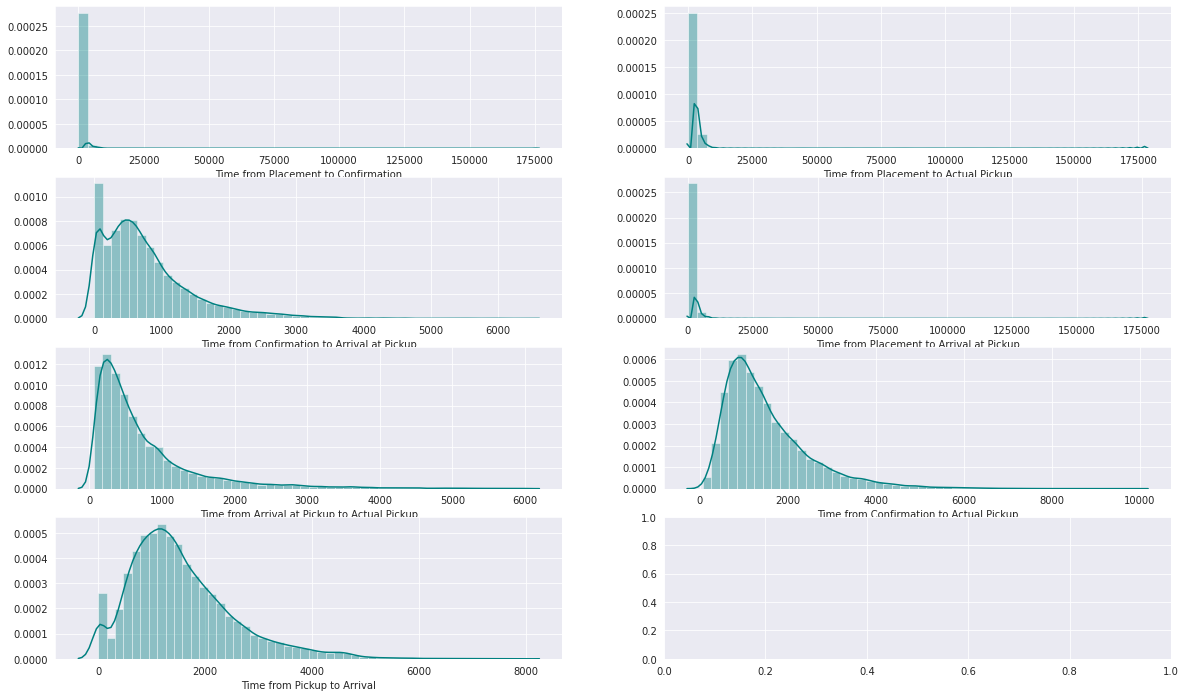

In [171]:
generateMultiPlot(
    df = train_data,
    variables = numeric_time_vars_sub[0:3] + ['Time from Pickup to Arrival'] + numeric_time_vars_sub[3:],
    nrows = 4,
    ncols = 2,
    length = 12,
    width = 20,
    func = sns.distplot
)

Next we look at the relationship between our new time variables with the target. See figure below. None of them seem to have any interesting characteristics with the target. Not by the look at these visuals. However, instead of subjectively discarding them, we'll lets models decide in a later section (Feature Selection). For now, we'll attempt to get other transformations from then and see if we can get a signal. See the upcoming tasks.

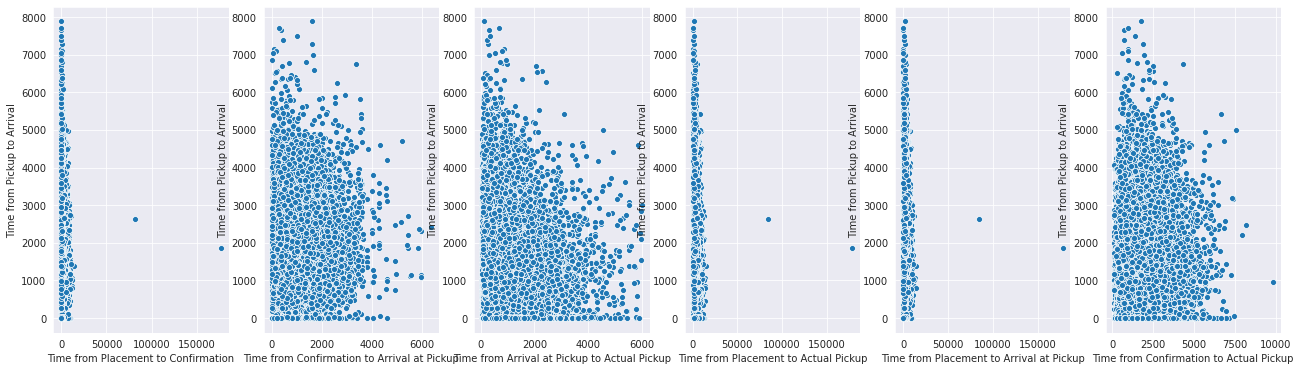

In [172]:
fig , axes = plt.subplots(1, 6, figsize = (22, 6))
for i in range(0, len(numeric_time_vars_sub)):
    var = numeric_time_vars_sub[i]
    sns.scatterplot(
        data = train_data, 
        x = var, y = 'Time from Pickup to Arrival', ax = axes[i])

###### task: extract the AM/PM feature, and visualise
The original time columns came in the form of obects. In these objects it is displayed the hour, the minute, the second as well as whetehr its AM/PM. Is it possible that whether it AM or PM is predictive of our target variable. Maybe orders delivered before 12 noon generally take more time because of traffic situations in the morning. Or the other way round. To investigate this we will extract the AM/PM attribute of the string objects and visualise. 

In [173]:
train_data.loc[:, time_vars].head()

Placement - Time Confirmation - Time Arrival at Pickup - Time Pickup - Time
0       9:35:46 AM          9:40:10 AM              10:04:47 AM   10:27:30 AM
1      11:16:16 AM         11:23:21 AM              11:40:22 AM   11:44:09 AM
2      12:39:25 PM         12:42:44 PM              12:49:34 PM   12:53:03 PM
3       9:25:34 AM          9:26:05 AM               9:37:56 AM    9:43:06 AM
4       9:55:18 AM          9:56:18 AM              10:03:53 AM   10:05:23 AM

The function below takes as imput a dataframe with time strings as columns and returns a new dataframe with new columns indicating the AM/PM attribute of the time strings. It also returns a list object containing the names of the new columns.

In [0]:
# helper function to get the AM/PM attribute
def getAM_PM(df):
    df = df.copy()
    am_pm_vars = list()
    for column_name in time_vars:
        new_column_name = '{}_made_AM/PM'.format(column_name.split('-')[0].replace(' ', ''))
        am_pm_vars.append(new_column_name)
        df[new_column_name] = df.loc[:, column_name].map(lambda string: string.split()[1])
    return df, am_pm_vars

In [175]:
# applyt function to both train and test data
train_data, am_pm_vars = getAM_PM(train_data) 
test_data, am_pm_vars = getAM_PM(test_data) 
train_data.loc[:, am_pm_vars].head()

Placement_made_AM/PM  ... Pickup_made_AM/PM
0                   AM  ...                AM
1                   AM  ...                AM
2                   PM  ...                PM
3                   AM  ...                AM
4                   AM  ...                AM

[5 rows x 4 columns]

Visualising the AM/PM columns and their relationship with the target, there's clearly not much in there. Also, since they represent the same information, in the models we build later we'll include only the AM/PM attribute relating to pickup.

In [176]:
fig, axes = plt.subplots(1, 4, figsize = (16, 6))
for axe, col in zip([0, 1, 2, 3], am_pm_vars):
    sns.boxplot(data = train_data, x = col, y = 'Time from Pickup to Arrival', ax = axes[axe])

###### task: extract the pickup hour and pickup minute and visualise
Another idea would be to extract the particular hour and the minute an order is picked up by the rider. From the columns displayed in the table below we can now use the .hour and .minute methods of datetime objects to get the hour and minute in separate columns.

In [177]:
train_data.loc[:, datetime_vars].head()

Placement  ...              Pickup
0 2020-01-09 09:35:46  ... 2020-01-09 10:27:30
1 2020-01-12 11:16:16  ... 2020-01-12 11:44:09
2 2020-01-30 12:39:25  ... 2020-01-30 12:53:03
3 2020-01-15 09:25:34  ... 2020-01-15 09:43:06
4 2020-01-13 09:55:18  ... 2020-01-13 10:05:23

[5 rows x 4 columns]

The function below takes as input a dataframe object with time columns represented as timestamps. It then returns a new dataframe object with both the hour and minute columns separately. Also, returns a list object containing the names of the new column names.

In [0]:
def getHourMinute(df):
    df = df.copy()
    hour_vars = list()
    minute_vars = list()
    for col in datetime_vars:
        hours = list()
        minutes = list()
        for order in df.index.values:
            hour = df.loc[:, col][order].hour
            minute = df.loc[:, col][order].minute
            hours.append(hour)
            minutes.append(minute)
    #     print(col)
    #     print(hours, minutes)
        new_column_name_hour = '{}_hour'.format(col)
        new_column_name_minute = '{}_minute'.format(col)
        hour_vars.append(new_column_name_hour)
        minute_vars.append(new_column_name_minute)
        
        df[new_column_name_hour] = hours
        df[new_column_name_minute] = minutes
    return df, hour_vars, minute_vars

In [179]:
# apply function to both train and test data
train_data, hour_vars, minute_vars = getHourMinute(train_data)
test_data, hour_vars, minute_vars = getHourMinute(test_data)
train_data.loc[:, hour_vars + minute_vars].head()

Placement_hour  Confirmation_hour  ...  ArrivalatPickup_minute  Pickup_minute
0               9                  9  ...                       4             27
1              11                 11  ...                      40             44
2              12                 12  ...                      49             53
3               9                  9  ...                      37             43
4               9                  9  ...                       3              5

[5 rows x 8 columns]

Visualising the pickup hour distribution plot in the figure below, we see that orders are mostly picked up by rider from aroung 8am and 8 pm. Only a few orders are picked up outside of these hours. There seems to be one order thats picked up at 12 midnight. We simply replace this value with the mean of pickup hour.  This makes sense as these are probably the working hours for sendy. Most frequently the pickup minute is 0, 24, 40 and 60. This indicates that orders probably go out in intervals of 20 minutes. For example, at 8:00 am, 8:20 am, 8:40 am, 9:00am and so on. The relationship of both pickup hour and pickup minute with the target are displayed in the lower panel of the figure. What we see here is that orders pickep up around 9 and 11 am are usually associated with longer delivery time than others. This is definately information that will be useful to our models. The pickup minute does not display any trends with the target.

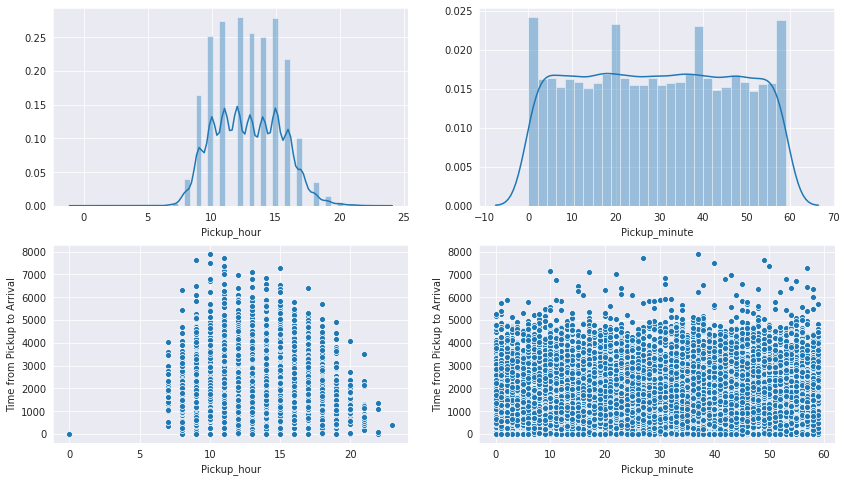

In [180]:
fig, axes = plt.subplots(2, 2, figsize = (14, 8))
sns.distplot(train_data['Pickup_hour'], ax=axes[0,0])
sns.scatterplot(data=train_data, x= 'Pickup_hour', y='Time from Pickup to Arrival', ax=axes[1,0])

sns.distplot(train_data['Pickup_minute'], ax=axes[0,1])
sns.scatterplot(data=train_data, x= 'Pickup_minute', y='Time from Pickup to Arrival', ax= axes[1,1])

In [0]:
# relacing the outlier value with mean. Dos so fror the test data as well
ind_to_replace = train_data[train_data['Pickup_hour'] == 0].loc[:, 'Pickup_hour'].index
train_data.loc[ind_to_replace, 'Pickup_hour'] = np.mean(train_data['Pickup_hour'])
ind_to_replace = test_data[test_data['Pickup_hour'] == 0].loc[:, 'Pickup_hour'].index
test_data.loc[ind_to_replace, 'Pickup_hour'] = np.mean(train_data['Pickup_hour'])

###### task: generate interactions between hour and minute, and visualise
Hour is a discrete variable. Its either its the 4th hour or not. We propose that to capture the granularity of the pickup time feature it may be helpful to attempt to make it continuous. We do so by adding the minute onto the hour. However, since minites range from 0 to 60, adding the raw like that will result in a not so interpretable variable. So first we convert the minutes to be continuous as well by dividing 60 by 100 so that now 30 minites is represented by a continuous value 0.50. Like wise 45 minutes becomes 0.75 and so on. When we add for example 30 minute to the 9th huor we will get 9.5 instead of 9.30. The function below does just that. It takes as input a dataframe object with both pickup minute and pickup hour columns as computes the columns we discussed above. Additionally it computes a multiplication as well. Just so we can have another option of getting these columns together. 

In [0]:
def generateInteractionHourMinute(df):
    df = df.copy()
    df['add_hour_minute'] = df['Pickup_minute'].div(60).add(df['Pickup_hour'])
    df['int_hour_minute'] = df['Pickup_minute'].div(60).mul(df['Pickup_hour'])
    return df

In [0]:
# apply function to both train and test data
train_data = generateInteractionHourMinute(train_data)
test_data = generateInteractionHourMinute(test_data)

Next we plot the distributions of the newly generated time variables. See upper panel of the figure below. We also plot their relationship with the target in the lower panels.

In [184]:
fig, axes = plt.subplots(2, 2, figsize = (14, 9))
sns.distplot(train_data['add_hour_minute'], ax=axes[0, 0])
sns.scatterplot(data = train_data, x = 'add_hour_minute', y = 'Time from Pickup to Arrival', ax=axes[1, 0])

sns.distplot(train_data['int_hour_minute'], ax=axes[0, 1])
sns.scatterplot(data = train_data, x = 'int_hour_minute', y = 'Time from Pickup to Arrival', ax=axes[1, 1])

The add_hour_minute variable should display a similar distribution as the hour feature we generated in the previous task. It should however be continuous like we see in the above visualisations. Looking at the plot on the of the lower panel it can be said that orders picked up between 8 and 9 and those that are picked up between 6 and 8 may have simimar average values for the target. Now the difference, interms of time between these observation is not a large as the plot would have us believe. Remember this is time, it is cyclical. 24 and 8 on the x axis are close values, but because the plot goes from smallest to highest, it seems like they are far apart. In the next task we go deeper into this and investigate the effect of the cyclical nature of time on the target.

###### task: compute pickup seconds after midnight (time is cyclical afterall) and visualise
To model the cyclicality of time we need time values that measure distance from a base time. For example, if we say our base is 12 midnight, then an order pickup up at 8 am, will have a values of 480 minutes for this variable. It measures time as a distance from a base. Almost similarly to the way a clock would. To get these values in the cell below we right a function that take in a time object. Compares that with the base time 12 midnight and the calculates the different. The difference is returned in seconds.

In [0]:
def getSecondsPastMidnight(x):
    date = x.date()
    twelve = pd.to_datetime(str(date) + ' ' + '00:00:00 AM')
    diff = x - twelve
    return diff.total_seconds()

In [0]:
# applying the function to both train and test data
train_data['seconds_past_midnight'] = train_data['Pickup'].map(getSecondsPastMidnight)
test_data['seconds_past_midnight'] = test_data['Pickup'].map(getSecondsPastMidnight)

The next step is to transform the secondsPastMidnight values using two functions, the sine and the cosine. The function are largely used in economics to model cyclical variables like GDP of Business cycles. Here we apply the techniques to the pickup time of orders. Below is a function that utilses numpy's sin and cos functions to get the transformatiion. Note that we apply the transformations to the seconds_past_midnight values after multiplying them by pi and dividing by the total number of seconds we have in a day. See the code cell below.

In [0]:
def generateSinCosTime(df):
    seconds_in_day = 24*60*60
    df = df.copy()
    df['sin_pickup_time'] = np.sin(2*np.pi*df['seconds_past_midnight']/seconds_in_day)
    df['cos_pickup_time'] = np.cos(2*np.pi*df['seconds_past_midnight']/seconds_in_day)
    return df

In [0]:
# apply function to both train and test data
train_data = generateSinCosTime(train_data)
test_data = generateSinCosTime(test_data)

Now visualising the cosine transformation on the y axis and the sine transformation on the x axis results in a feature that look like this. Look at this as a clock. After 12 midnight for example there is only one order that is pickup. Most of the activity happens from morning and during the day and less pickups are done as we go into the night. Note that these two columns go together to help models learn from the cyclicality of time.

In [189]:
train_data.plot.scatter('sin_pickup_time','cos_pickup_time').set_aspect('equal')

##### Weekday and Monthday variables
By now we've probably done so much with the time variables. Next we go to the weekday and monthday variables. The come with the datset in form of integers from 0 to 6 for weekdays and 1 to 31 for monthdays. These are certainly not numeric variables. We could say they are numeric discrete but that would likely negatively affect the learning process of our models. How so? Models will learn the inherent ordering of the values as if it had meaning when in reality it has no meaning. Luckily for us we can add meaning to them. See the upcoming tasks.

###### task: get days of the week for weekdays
The week day variable consists of 7 values 0 for monday all the way to 6 for sunday. The cell below assigned each of the values their actual weekday name. Take input as dataframe object with a column 'Pickup - Weekday (Mo = 1)' and returns a new dataframe object with a new column "Pickup_weekday" that have the actual names of the days.

In [0]:
# helper function
def getWeekDays(df):
    df = df.copy()
    days_dict = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sart', 7:'Sun'}
    df['Pickup_weekday'] = df.replace({'Pickup - Weekday (Mo = 1)':days_dict})['Pickup - Weekday (Mo = 1)']
    return df

In [0]:
# apply function to both train and test data
train_data = getWeekDays(train_data)
test_data = getWeekDays(test_data)

Looking at the visual below (left panel), orders are most frequently picked up on thursdays. On weekend people order less. The relation ship between weekday and the target are show on the right panel. It is clear that certain days have higher average values of the target than others. Sunday for instance. But then again only a few orders in that dataset occur on sundays, thus that pattern varies a lot. See the error bars. We could feed this feature directly to the models we build later as dummy variables. However, that will increase our feature space and for a variable that doesn't even show potential of producing good predictions. A way around this would be to explore an alternative encoding technique. Ordinal encoding. We already used this transformation to visualise the rider ids in a previous section. We'll use it again hear to produce an ordinally encoded weekday variable. This has the advantage that it does not increase the dimensionality of our dataset.

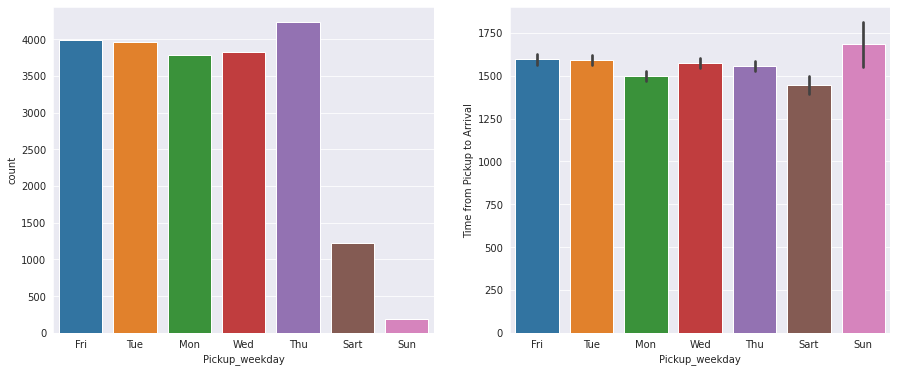

In [192]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.countplot(data = train_data, x = 'Pickup_weekday', ax = axes[0])
sns.barplot(data = train_data, x = 'Pickup_weekday', y = 'Time from Pickup to Arrival', ax = axes[1])

###### task: apply ordinal encording to weekdays and monthdays and visualise
The way we add meaning to numerical meaning to variables that would otherwise be categorical like day of the week is by a process known as ordinal encoding. With the weekday feature, the encoder will look at each day of the week's average value of the target. Days will then be ordered from 0 to 6 based on the average value of the target. From low to high. Note that the month days can also be applied this technique. We go ahead and do so below. 

In [0]:
# make month day a string - input should be an object
train_data['Pickup - Day of Month'] = train_data['Pickup - Day of Month'].map(str)

In [194]:
enc = OrdinalCategoricalEncoder(encoding_method='ordered', variables = ['Pickup_weekday', 'Pickup - Day of Month'])
X = train_data[['Pickup_weekday', 'Pickup - Day of Month']]
y = train_data['Time from Pickup to Arrival']
X_test = test_data[['Pickup_weekday', 'Pickup - Day of Month']]

enc.fit(X, y)
train_data['Pickup_weekday_ordered'] = enc.transform(X)['Pickup_weekday']
train_data['Pickup_dayofmonth_ordered'] = enc.transform(X)['Pickup - Day of Month']
test_data['Pickup_weekday_ordered'] = enc.transform(X_test)['Pickup_weekday']
test_data['Pickup_dayofmonth_ordered'] = enc.transform(X_test)['Pickup - Day of Month']

/usr/local/lib/python3.6/dist-packages/feature_engine/base_transformers.py:91: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories does not exist. Try using the RareLabelCategoricalEncoder to remove infrequent categories before calling this encoder.
  "NaN values were introduced in the returned dataframe by the encoder."


After the algorithm is done, part of the output is a dictionary that show the new mappings of the categories. For example, the output below say that sartuday will be given the value 0 and Sunday the value 6. In other words Time from pickup to arrival tends to be lowest on Saturdays and highest on sunday. We can go on and visualise the results. See below.

In [195]:
enc.encoder_dict_['Pickup_weekday']

{'Fri': 5, 'Mon': 1, 'Sart': 0, 'Sun': 6, 'Thu': 2, 'Tue': 4, 'Wed': 3}

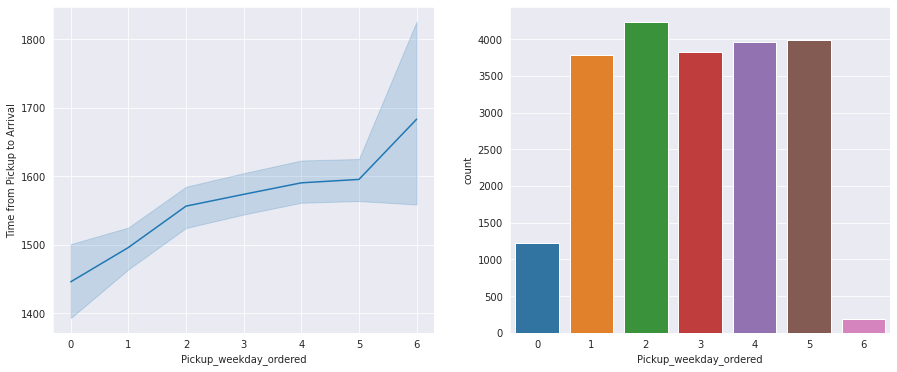

In [196]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.lineplot(data = train_data, x = 'Pickup_weekday_ordered', y = 'Time from Pickup to Arrival', ax=axes[0]
)
sns.countplot(data = train_data, x = 'Pickup_weekday_ordered', ax=axes[1]
)

We get a feature that looks as above. Now the relationship between the days and the target is much clear. So instead of introducing more columns to our data through one hot encoding, this is what we will do. Below we show the same visuals after conducting a similar procedure for the month day variable. With it, we also get a good looking variable. See below.

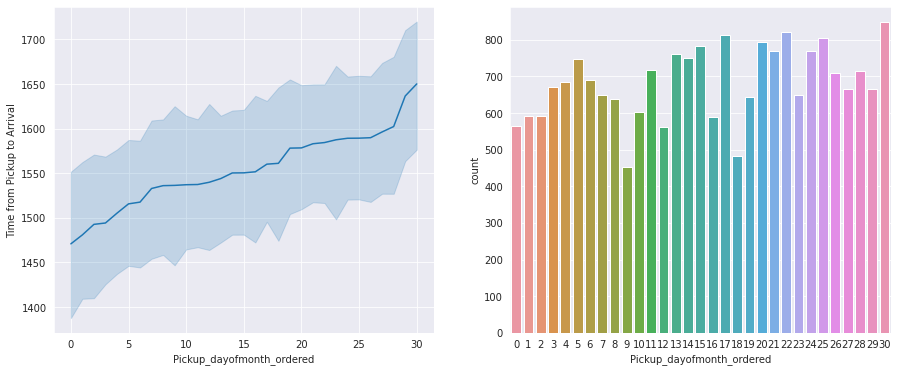

In [197]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.lineplot(data = train_data, x = 'Pickup_dayofmonth_ordered', y = 'Time from Pickup to Arrival', ax=axes[0]
)
sns.countplot(data = train_data, x = 'Pickup_dayofmonth_ordered', ax=axes[1]
)

###### task: evaluate the efficacy of the is_weekday feature
Finally we will create a binary indicator. The purpose of this indicator is to tell whether an order is occuring on a weekend or not. This may improve model if there is a difference in the distribution of the target when it is a weekend and when it is a weekday. The function below conducts that operation and return a new dataframe object with our column of interest.

In [0]:
def isWeekend(df):
    df = df.copy()
    df['is_weekend'] = np.where(df['Pickup_weekday'] == 'Sart', 'Weekend',
                                    np.where(
                                        df['Pickup_weekday'] == 'Sun', 'Weekend', 'Weekday')
                                    )
    return df

In [0]:
# apply function to both train and test data
train_data = isWeekend(df = train_data)
test_data = isWeekend(df = test_data)

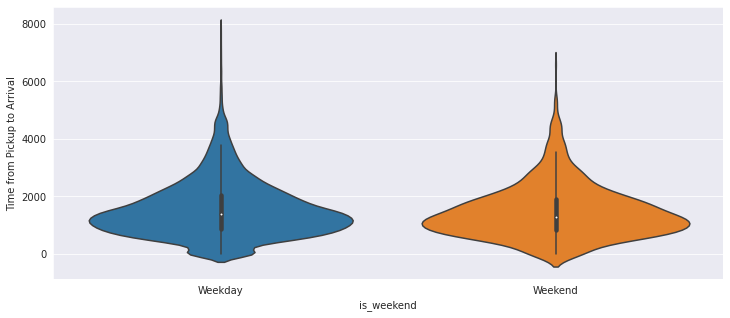

In [200]:
fig = plt.figure(figsize = (12, 5))
sns.violinplot(data = train_data, x = 'is_weekend', y = 'Time from Pickup to Arrival')

The difference is there, only small.

##### Conclude
This conclude the analysis of time variables. The variable transformation done here will be included in modelling later. However, because there isn't really much signal in these feature, we should be careful to investigate whether these transformations add anything interms of predictive accuracy in the models we build later.

###### Output
The output from this section is a list object that contains the names of the variables that we extracted from time variables and month and week day variables.

In [201]:
raw_predictors

['Pickup - Weekday (Mo = 1)',
 'Platform Type',
 'Pickup Long',
 'No_Of_Orders',
 'Pickup Lat',
 'Pickup - Day of Month',
 'Average_Rating',
 'Age',
 'Personal or Business',
 'No_of_Ratings',
 'Distance (KM)',
 'Destination Lat',
 'Destination Long',
 'Temperature_missing']

In [202]:
time_transformations = [
       'Time from Placement to Confirmation',
       'Time from Confirmation to Arrival at Pickup',
       'Time from Arrival at Pickup to Actual Pickup',
       'Time from Placement to Actual Pickup',
       'Time from Placement to Arrival at Pickup',
       'Time from Confirmation to Actual Pickup',
       'Pickup_made_AM/PM', 'Pickup_hour', 'Pickup_minute',
       'add_hour_minute', 'int_hour_minute', 'seconds_past_midnight',
       'sin_pickup_time', 'cos_pickup_time', 'is_weekend',
       'Pickup_weekday_ordered', 'Pickup_dayofmonth_ordered'
]

train_data.loc[:, time_transformations].head()

Time from Placement to Confirmation  ...  Pickup_dayofmonth_ordered
0                                264.0  ...                         29
1                                425.0  ...                         27
2                                199.0  ...                         28
3                                 31.0  ...                         13
4                                 60.0  ...                         17

[5 rows x 17 columns]

Also, the Pick-up month day column will be encoded back to integer as was before.

In [0]:
train_data['Pickup - Day of Month'] = train_data['Pickup - Day of Month'].astype(int)

## Geospatial variables

###### task: Check validity of target Geospatial data
When generating a geopy calculation of distance for latitude and longitude variables we look for whether the distance (km) variable follows the same trend as the geopy distance (calculated using the latitude and longitude geospatial features of the data). The trend should mean that a unit change of distance is followed by a change in time from pick up to arrival (when holding all other variables constant) in a positive direction. If the distance data also follows a similar trend to the geopy data we can confirm validity of the geopspatial data. Furthermore, we are interested in the granularity of the data. With more granular data we can have more precise distance information that we may want to use during feature engineering. Therefore, a comparison is done between the granularity of the distance (km) and the newly created geopy data.

In [0]:
# Check distance variable by computing against distance with geopy module for latitude and longitude variables
def compute_distance(row):
    src = (row["Pickup Lat"],row["Pickup Long"])
    dest= (row["Destination Lat"],row["Destination Long"])
    return distance.distance(src,dest).km

In [0]:
# Compute the geopy distance for the train and test data
train_data["geopy_distance"] = train_data.apply(compute_distance,axis=1)
test_data["geopy_distance"] = test_data.apply(compute_distance,axis=1)

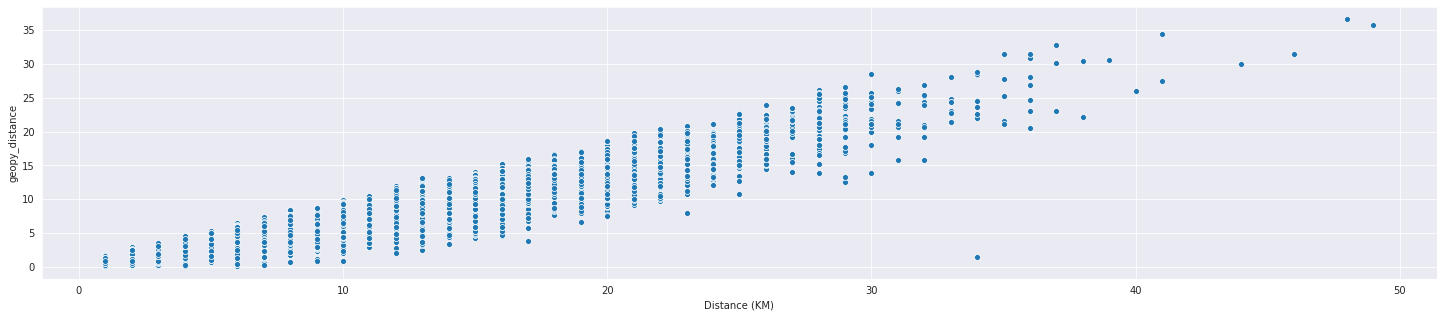

In [206]:
# Confirm that geopy and distance(km) follow the same trend
plt.figure(figsize=(25,5))
sns.scatterplot(train_data["Distance (KM)"], train_data["geopy_distance"])

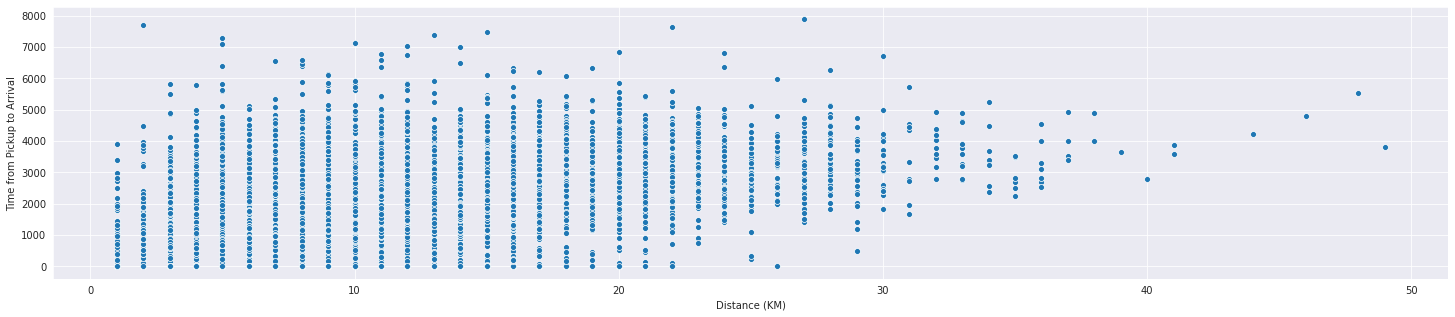

In [207]:
# Check the trend of the distance (km) variable against the target variable and check the granularity of the data
plt.figure(figsize=(25,5))
sns.scatterplot(train_data["Distance (KM)"], train_data["Time from Pickup to Arrival"])

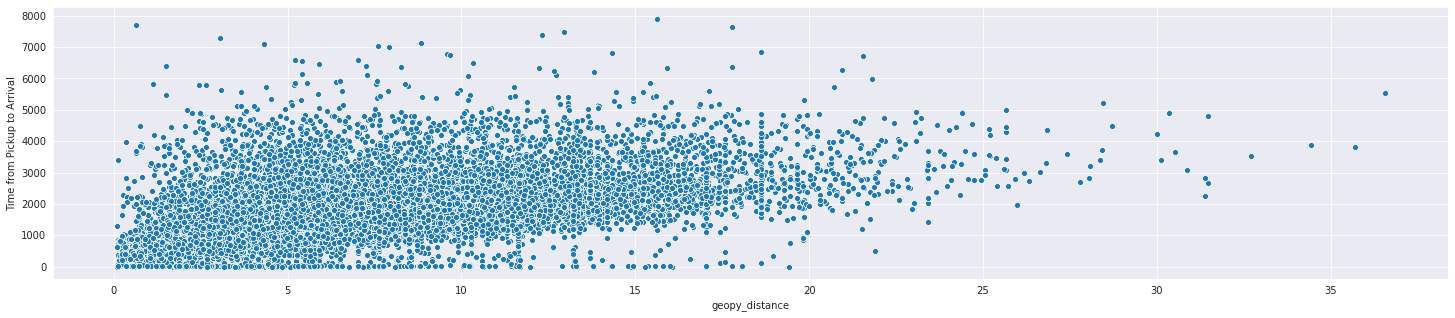

In [208]:
# Check the trend of the geopy variable against the target variable and check the granularity of the data
plt.figure(figsize=(25,5))
sns.scatterplot(train_data["geopy_distance"], train_data["Time from Pickup to Arrival"])

Conclude

The granularity of the geopy generated feature for distance (in comparison to the originally provided distance feature) shows:



*   Similar trend in the shape of the data points
*   The geopy data points are more dense and may account for discrete aspects of the originally provided distance feature's data points.

The above observation may be useful when looking into feature engineering and feature selection.






## Factor variables

###### task: plot barchars for factors


In [209]:
train_data.loc[:, factor_vars].describe()

Vehicle Type Personal or Business  Platform Type
count         21201                21201          21201
unique            1                    2              4
top            Bike             Business              3
freq          21201                17384          18054

Vehicle type consists of only a single level. This variable is a candidate for droping. Personal or business has 2 levels, the most frequently occuring is Business. Lastly, Platform type has 4 levels, the most frequently occuring is type 3. It is also clear that there is a huge class imbalance among these features. The most frequent occurances for both business type and Platform type occur in more that 70% of the training data. Lets investigate these further by form of visualisations.

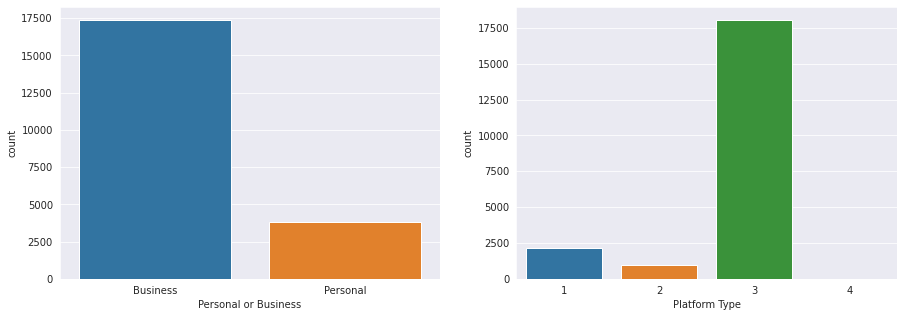

In [210]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(data = train_data, x = 'Personal or Business', ax = axes[0])
sns.countplot(data = train_data, x = 'Platform Type', ax = axes[1])

Look at that. Personal or business indicates that most deliveries are for business customers. Personal order occur infrequently. Similarly, the most commonly used platform type is type 3 while 1 and 2 occur infreqquently. Platform Type 4!.

# Predictive Modelling
Finally, we reach the modelling section. This is were we fit multiple and hopefully diverse predictive models. Out initial models was a multiple linear regression and it cross validated perfomance was a rmse of 797. This translated to an error rate of about 51%. Now that we have done EDA and evaluated the quality of our data and made improvemnents were possible, it is time to implements various model and evaluate the efficiency of the data tranformations we've done so far.


## An Overview of learners
The list of models we will train is as follows:
1. Linear regression - we will agian fit the linear model to see if its perfomance increases by the inclusion of the newly transformed variables.
2. Lasso - Given that we have done many transformations of the data, the dimensionality of our data has increased significantly. Lasso is a variation of the linear model that basically takes care of the dimensionality problem. More will be explained later.
3. Ridge - For the same reason as Lasso.
4. KNearestNeighbors - It is possible that our data may be non linearly related to the target. A knn is a non linear model and may learn better if the data has non linear patterns
5. DecisonTree - for the same reason as Knn.
6. RandomForest - RandomForest is an extension of DecisionTrees that has less variabilty that decision tree because of its bagging approach. More is explained later.
7. Stochastic Gradient Boost - This is yet another extension of DecisionTrees that tends to be more accurate because of the clever approach it takes to building trees. More is explined later.

### Linear Regression
Linear regression is a parameterised model that use an ordinary least squares (ols) approach to fitting a hyperplane to a to a dataset that consists of multiple predictors. It does so by minimising the sum of squared errors (SSEs) where SSE is computed by takeing the difference between the actual and predicted values and squaring it, and finally adding these values together. The resulting parameters in ols are said to be of minimum variance and low bias, but only if certain assumptions of ols are met, such as normally distributed errors and the predictors are independent. Note that if these assumptions are not met, it is recommended to implement other approaches.
### Lasso
Least Absolute Shrinkage and Selection Operator (Lasso) is a regularisation technique. Is is also a variation of the linear model that attempts to improve the perfomance of ols when independent variables are highly correlated. Note that when predictor variable are collinear, the parameters estimated by ols tend to be inflated and have high variance. The word "shrinkage" in Lasso means that the method shrinks these parameters by minimising a loss function that is an extension of the SSEs. It extends on the SSEs in the sense that an extra term is required that is known as L1 regularisation that pernalises increases in ols parameters for any increases that do not result in a corresponding decrease in SSE. Lasso has the ability to shrink the parameters all the way to zero such that they don't form part of the model spcification, thus it is said to conduct feature selection in that way.
### Ridge
Ridge regression is also an extension of the linear model. Works similarly to Lasso by shrinking parameter estimates, although it does not remove them completely from the model. In that way it also works well with highly correlated predictors. Although the ols parameter estimates are not reduced to zero, the model variance is definately reduces. Note that both Lasso and Rigde reduce the model's variance by introducing some bias into the model. Often times this results in lower SSEs.
### K-Nearest Neigbors
K nearest neighbors is an algorithm that works by computing distances between samples in a multi dimensional space. During training the model simply computes the relative position of the training samples in that space and stores them, thats all. Next when a new sample arrives, its relative position in the space is determined and its prediction is based on its closest neighbors in the training dataset. To compute closeness, several distance measures can be used. The most popular ones are the Eucledean distance and the Manhattan distance. The number of neighbors that are considered to make a prediction (K) can be set by the user or determined by the data through cross validation. Once K is know, the prediction is the average value of the K closest neighbors in the case of regression problems. This model is very sensitive to different scales among predictor variables, thus may require us to do that preprocessing before hand. Other than that it can produce predictions that are as good or better than linear regression especially for non linear associations.
### Decision Tree
The Decision tree model uses a non parameterised approach to making predictions. Its basically a series of questions that the algorithm asks about a particular sample. For example, if the value is this then the target is that. The algorithm starts off by selecting a variable that produces the best split of the data. Every predictor is assigned an impurity scores based on how accurate its predictions are (measured by rmse). The feature with the lowest impurity score is used for the initial split at the top of the tree, know as the root node. The other variables are used for splits down the tree all the way to the final predictions at the leaf nodes. Trees can easily overfit the training data because of their slightly more complex nature compared with linear models. Therefore it is common to build a tree to maximum depth and then prune it by getting rid of branches that do not necessarily result in significantly lower rmse in the next node. Finally, tree can easily decipher non linear patterns in dataset and thusare often useful for non linearly distributed datasets. 
### Random Forest
Random Forest is an extension of decision trees. Single decision tree often have high variance. Their predictions depend a lot on the data they were trained on. A slight change to the training set, their predictions change significantly. Because of this a popular technique is on of building multiple trees and averaging their predictions. This is known as bootstrap aggregation, meaning multiple models are trained on different subsets of the training data. The subsets are obtained through a bootstrap sampling approach where samples can be randomly selected more than once until the length of the bootstrap is equal to the length of the original training set. Note that some of the samples are left out (refered to as out of bag samples). The model is then trained on the bootstrap sample. Random forest takes sampling to yet another level by also using a subset of the predictors to build each tree. This results in not so highly correlated tree in the forest that if averaged can produce stable predictions with little variance. The user has the option to choose the number of tree of treat it as a hyper-paramer to be determined by the data.
### Stochastic Gradient Boost
Stochastic Gradient Boost is yet another variation of tree models. The algorithm starts off by making a naive prediction of the target as the average value for all samples. It then computes the residuals (errors) as the diffence between the actual values and the naive prediction. The tree is then build to accurately predict the residuals. Next, each sample in the dataset if dropped at the root node of the tree and a prediction is made (based on residuals). The predicted residual for each sample is then added to the initial naive prediction to get a new prediction. Based on these new predictions another set of residuals is computed. A tree is built to predict them. And then each sample is thrown at the tree and a prediction is made. This prediction is again added to the initial predictions to get updated predictions. And then a new set of residuals is computed and the process is repeated. The idea is that the residuals will keep getting smaller and smaller and therefore the predictions closer and closer to the actual values. After only a few iteration this algorithm can produced predictions that are very accurate in the training set but not so much in a testing dataset. Therefore in practice, the process of adding the predicted residuals to the previous predictions is controlled by a parameter known as the learning rate, value between 0 and 1, so that not the entirety of the predicted residuals is added to previous prediction. The lower this value the longer it takes the algorithm to converge. The number of trees that can be built depends on the user or can be determined by the data through cross validation procedures.

## An Overview of predictors
Having gone through the section of=n EDA, we will not spend much time here. We will just get our predictors in order. The main purpose of this section is to evaluate the effectiveness of the EDA and feature engineering done in previous sections. As such, we want to fit models increamentally. We start off by fitting the set of models discussed above to the raw predictor set. This consists of the variables that came with the dataset in their raw form, without any transformations and excluding those that could not be fed into a model without being transformed first. That means these models won't use time variables as they could not be fed into a model without transfromation. These will also exclude variables that had missing values. Luckily for us, we already have a list object that stores these variables "raw_variables". The next set of models will be fit on raw predictors as well as the transformations we did for the numeric variables [rider_id_bins, speed_std, rider_speed etc]. Note that here we'll also have 'Temperature' since we imputed the missing values in this section. We'll tehn look at how the models improve on this data. The next set of models will be fit on raw features plus numeric transformations plus time transformation. This means we'll include columns such as [Time from placement to confirmation, pickup_hour, pickup_weekday_ordered etc]. Lastly, we'll fit models with an an extra column for distance, the geopy distance computed based on Longitude and Latitude data. We hypothesis that this feature should approximate distance between location better than the provided Distance variable which is descrete. The code cells below create a dictionary whose keys are strings describing what variables the dictionary values contain. The idea is later we loop through these values.

In [0]:
predictors = {
    'Raw features': raw_predictors,
    'Raw + numeric transformations': raw_predictors + numeric_transformations,
    'Raw + numeric + time transformations': raw_predictors + numeric_transformations + time_transformations,
    'Raw + numeric + time + geo transformations': raw_predictors + numeric_transformations + time_transformations
}

When we fit models with time transformation 'Pickup - Day of Month' and 'Pickup - Weekday (Mo = 1)' are redundant as we have transformed the variables using ordinal encording. In the cell below we remove them from the predictor list.

In [0]:
predictors['Raw + numeric + time transformations'].remove('Pickup - Day of Month')
predictors['Raw + numeric + time transformations'].remove('Pickup - Weekday (Mo = 1)')

Similarly, when we fit the models with geo-spartial transformation we exclude day of week and day of mnth as they are already in time transformation as ordered variables. We also append geopy_distance.

In [0]:
predictors['Raw + numeric + time + geo transformations'].remove('Pickup - Day of Month')
predictors['Raw + numeric + time + geo transformations'].remove('Pickup - Weekday (Mo = 1)')
predictors['Raw + numeric + time + geo transformations'].append('geopy_distance')

## A Primer on Cross Validation

To get truer and more reliable estimates of each model's perfomance we will use a cross validation scheme. Cross validation is paramount particularly because certain models are inherently unstable. For example Decision tree models. The change their predictions an lot nd therefore their perfomance from sample to sample varies. We don't want a situation where we evaluate it's perfomance on a single test set. If it's perfomance on that single test set is high we may be led to a false conclusion if on the next test set =, its perfomance will be poor. Cross validation tests the perfomance of a model on multiple test sets known as validation sets and estimate the model's perfomance as the average perfomance across all the validation set. This has the advantage that it allows the practitioner to analyse and spot the variability of each model as we will see below. A popular Cross validation technique is KFold cross validation. K is determined by the user, we will use 10 for this value. It often produces true and unbiased model perfomance statistics and it is simple to implement using sklearn's KFold class. Below we write a function (modelEval) that uses the class to generate train and test indices. We then use these indices to resample the data, fit and evaluate a regressor 10 times. The function takes as input the estimator, the predictors data X, the target y and cv to indicate the K. The output is a tuple of two dataframe objects. The first is the output. output gathers the data that is used during the models training and testing phase. This is where we keep track of what samples were used for training, which ones were for testing in what Fold of the CV process etc. It also collects the actual target values, the the predicted values and the residuals per round of testing. The second dataframe return collect information related to the perfomance of the model, the rmse and the error rate.

In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def modelEval(estimator, X, y, cv):
    output = pd.DataFrame()
    perfomance = pd.DataFrame()

    cv = KFold(n_splits=cv)
    # train_data.loc[:, 'Rider Id']
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
#         print(i, train_index, test_index)
        X_train = X.loc[train_index, ]
        y_train = y.loc[train_index]
        X_val = X.loc[test_index, ]
        y_val = y.loc[test_index]

        X_train = pd.get_dummies(X_train, drop_first=True)
        X_val = pd.get_dummies(X_val, drop_first=True)

        col_names = X_train.columns.to_list()

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns = col_names)
        X_val = pd.DataFrame(scaler.transform(X_val), columns = col_names)



        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_val)
        residuals = y_val - y_pred
        data = X_val
        data['Actual'] = y_val
        data['Predictions'] = y_pred
        data['Residuals'] = residuals
        data['FOLD'] = 'Fold_{}'.format(i + 1)
        data['Index'] = test_index
        output = pd.concat([output, data])

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        err_rate = ((rmse / np.mean(y_val)) * 100).round(2)
        results = pd.DataFrame(
            {'FOLD': 'Fold_{}'.format(i + 1), 'RMSE': pd.Series(rmse), 'ERROR_RATE': pd.Series(err_rate)})
        perfomance = pd.concat([perfomance, results])
        
    return output, perfomance

## Model training
As we already discussed above, we fit multiple models on multiple predictor sets. The function below is designed to achieve that purpose. It takes as input a dictionary of the models we wish to fit. Also takes in a dictionary of the different predictor sets we use to fit a model at each round. Note that this function calls the modelEval() function we wrote above. It calls it multiple times as it iterates through the two dictionaries, one for estimators and the other for predictors. Remember modelEval() returns a tuple of 2 dataframe objects for a single estimator. This means the modelFit() function below should receirve that output for each model and stores it, name it properly before fitting the next estimator. This we do by defining 2 dictionaries. Each for the two outputs returned by modelEval(), OUTPUT and PERFOMANCE. The key in each dictionary is a string describing the predictor set and the value is the data for all models that have been fir repetitively by calling modelEval(). The output from the function are the two dictionaries, one for perfomance statistics and the other, the data output discussed above. Lets go ahead and implement the models.

In [0]:
def modelFit(estimators, predictors):
    OUTPUT = {}
    PERFOMANCE = {}

    for group, feature_set in predictors.items():
    #     print(group, feature_set)
        predictor_set = feature_set

        cv = 10
        X = train_data.loc[:, predictor_set]
        y = train_data.loc[:, 'Time from Pickup to Arrival']

        output = pd.DataFrame()
        perfomance = pd.DataFrame()
        variable_importance = pd.DataFrame()
        for model, estimator in estimators.items():
            out, perf = modelEval(estimator, X, y, cv)
            out['Estimator'] = model
            out['Predictors'] = group
            output = pd.concat([output, out])
            perf['Estimator'] = model
            perf['Predictors'] = group
            perfomance = pd.concat([perfomance, perf])
        OUTPUT[group] = output
        PERFOMANCE[group] = perfomance
    return OUTPUT, PERFOMANCE

This is the final code cell where we implement the models in a loop iteration. Input to the modelFit() function are the dictionaries 1. predictors defined in sections above and estimators define in the cell. You don't want to run this cell. But if you can wait about 60 minutes please do. We fit a random forest regressor with a 500 trees (n_estimators). The Gradient bossted regressor will train 200 trees. For the Decision tree regressor we leave the default parameters. Parameters, especially fro tree models will be explained more in a section dedicated to hyper-parameter tuning. It seemed redundant to go on and on about them if we are not going to use them. Models here are fitted mostly on default parameters. The same goes for Lasso and Ridge, we apply the full penalisation for the coefficients.

In [0]:
# ## DO NOT EXECUTE ### LOAD PICKLE FILES ###
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# estimators = dict(
#     Linear_model = LinearRegression(),
#     Lasso_l1 = Lasso(),
#     Ridge_l2 = Ridge(),
#     Knn = KNeighborsRegressor(n_neighbors = 20),
#     Decision_tree = DecisionTreeRegressor(),
#     Random_forest = RandomForestRegressor(n_estimators=500, random_state=111, n_jobs=-1),
#     Gradient_booster = GradientBoostingRegressor(n_estimators=200, random_state=111)
# )

# OUTPUT, PERFOMANCE = modelFit(estimators = estimators, predictors=predictors)

In [0]:
import pickle
# # Save outputs to pickle
# pickle.dump(OUTPUT, open("output.p", "wb"))
# pickle.dump(PERFOMANCE, open("perfomance.p", "wb"))

# load pickle files
OUTPUT = pickle.load(open("output.p", "rb"))
PERFOMANCE = pickle.load(open("perfomance.p", "rb"))

## Assessing model perfomance

In [409]:
PERFOMANCE['Raw features'].groupby('Estimator').mean().sort_values('RMSE')

RMSE  ERROR_RATE
Estimator                                
Gradient_booster   755.222317      48.503
Random_forest      765.977391      49.192
Ridge_l2           797.219449      51.198
Linear_model       797.226652      51.199
Lasso_l1           797.789502      51.235
Knn                886.965343      56.964
Decision_tree     1100.272545      70.681

In [410]:
PERFOMANCE['Raw + numeric transformations'].groupby('Estimator').mean().sort_values('RMSE')

RMSE  ERROR_RATE
Estimator                                
Gradient_booster   726.272966      46.641
Random_forest      746.018390      47.911
Linear_model       753.809346      48.410
Ridge_l2           753.821733      48.408
Lasso_l1           754.892115      48.477
Knn                877.019394      56.322
Decision_tree     1081.489563      69.460

In [411]:
PERFOMANCE['Raw + numeric + time transformations'].groupby('Estimator').mean().sort_values('RMSE')

RMSE  ERROR_RATE
Estimator                                
Gradient_booster   715.722750      45.960
Random_forest      736.233420      47.280
Ridge_l2           742.983015      47.711
Linear_model       743.463223      47.744
Lasso_l1           743.805568      47.765
Knn                961.508500      61.755
Decision_tree     1081.035332      69.443

In [412]:
PERFOMANCE['Raw + numeric + time + geo transformations'].groupby('Estimator').mean().sort_values('RMSE')

RMSE  ERROR_RATE
Estimator                                
Gradient_booster   717.181867      46.056
Random_forest      734.362425      47.161
Ridge_l2           742.067209      47.655
Linear_model       742.501450      47.683
Lasso_l1           742.940029      47.711
Knn                961.456669      61.752
Decision_tree     1062.359855      68.244

In [0]:
order = PERFOMANCE['Raw + numeric + time transformations'].groupby('Estimator').mean().sort_values('RMSE').index

In [414]:
all_data = pd.DataFrame()
for feature_set, data in PERFOMANCE.items():
    feature_set = feature_set
    results = data
    all_data = pd.concat([all_data, data])

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.pointplot(data=all_data, x='Estimator', y='RMSE', join=False, ax=axes[0], hue='Predictors', dodge=0.3, order = order)
# plt.title(feature_set)
sns.pointplot(data=all_data, x='Estimator', y='ERROR_RATE', join=False, ax=axes[1], hue='Predictors', dodge=0.3, order = order)
# plt.title(feature_set)

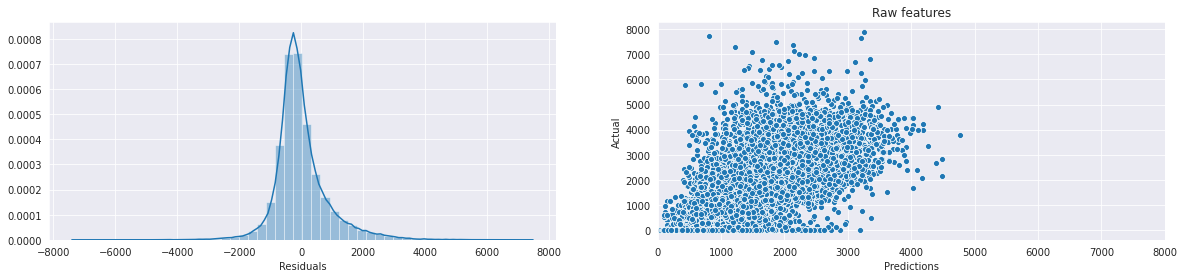

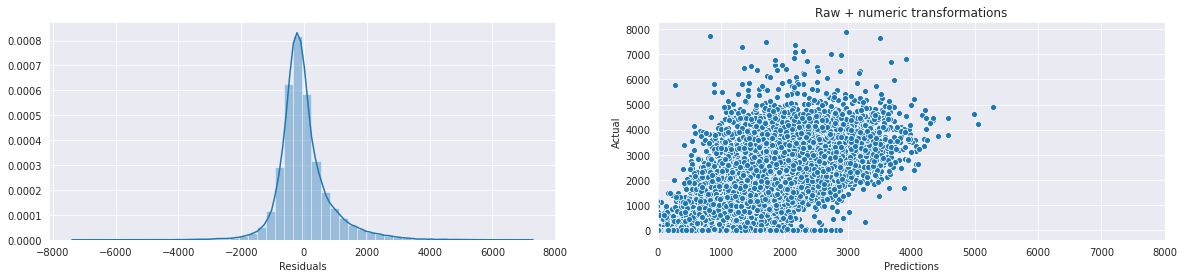

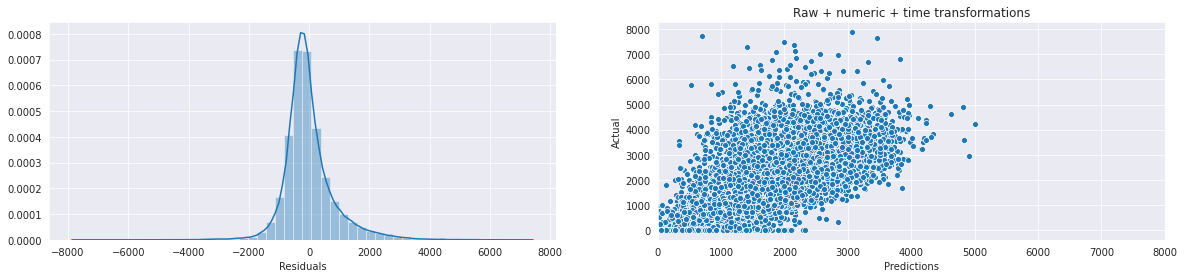

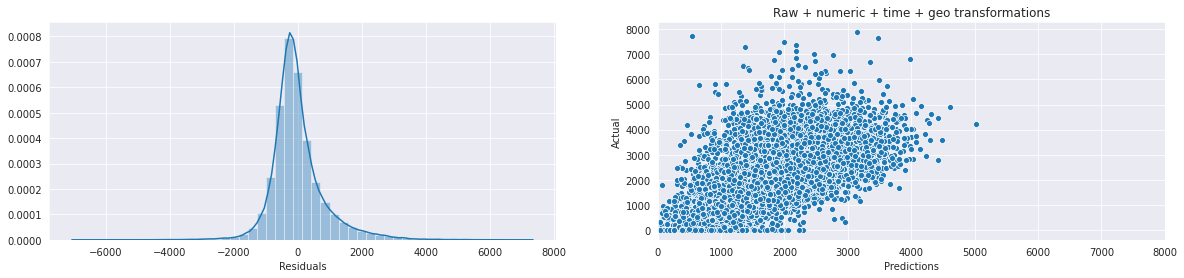

In [415]:
for feature_set, data in OUTPUT.items():
    feature_set = feature_set
    data = OUTPUT[feature_set]
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 4), sharex=False)
    fig = sns.distplot(data['Residuals'], ax = axes[0])
    fig = plt.title(feature_set)
    fig = sns.scatterplot(data = data[data['Estimator'] == 'Gradient_booster'], x = 'Predictions', y = 'Actual', ax = axes[1])
    fig = plt.xlim(0, 8000)

# Feature Selection

As we have seen above, the EDA and data transformation we did certainly improve model perfomance. We've from a linear model that is no better than guessing when making prediction to one that actually has predictive power. However, note that the amongst the many variable transformations we've introduced there are some like the geopy distance that do not necessarily improve model perfomance but simply increase the dimensionality of our data. I can bet there's more variables with this characteristic. This section is dedicated to dealing with just that. We begin by check for variables that have a nearly zero variance. These tend to have a negative effect on model perfomance. See following task.

###### task: identify near-zero variance features
Luckily for us sklearn comes with a class designed to achieve our task. VarianceThreshold, under the feature_selection module. We will apply the fit method to all the predictors we've transformed excluding geopy_distance. The transform method will then return an array indicating each variable's variance. We then convert this array to a dataframe and display it as below.

In [0]:
from sklearn.feature_selection import VarianceThreshold
varz = predictors['Raw + numeric + time transformations']
X = train_data.loc[:, varz]
X = pd.get_dummies(X, drop_first=True)

selector = VarianceThreshold()
X_trans = selector.fit_transform(X)

In [253]:
variances_data = pd.DataFrame(selector.variances_, index=X.columns, columns=['Variance']).sort_values('Variance', ascending = False).reset_index()
variances_data.head()

index  Variance
0      Time from Placement to Actual Pickup  178224.0
1  Time from Placement to Arrival at Pickup  177039.0
2       Time from Placement to Confirmation  176725.0
3                     seconds_past_midnight   80629.0
4   Time from Confirmation to Actual Pickup    9770.0

Next we want to visualise the variances. See visual below. We limited the x axis to betweet 0 and 50 because it allows us to see the variables with the really low variances. Note that by this method, a number of variables could be removed depending on the variance threshold we set. However, instead of manually setting the threshold, we let the data inform this decision. We fit multiple thresholds and select variables based on a training dataset. A model will then be fit on the selected variables and perfomance evaluated on a validation set. Note that this process is done on a 10 fold cross validation scheme to get a truer assessment of perfomance.

(0.0, 50.0)

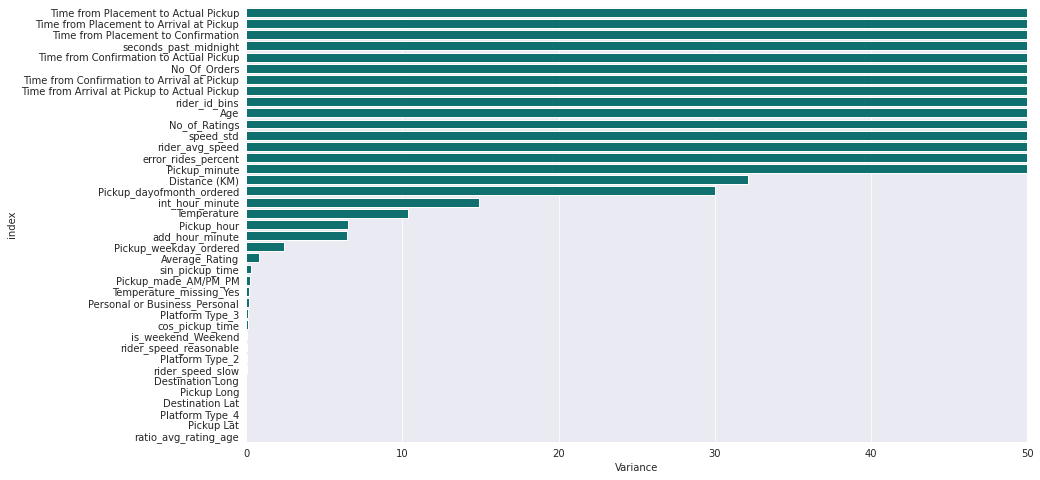

In [254]:
fig = plt.figure(figsize = (14, 8))
sns.barplot(data = variances_data, y = 'index', x = 'Variance', color = 'teal')
plt.xlim(0, 50)

Below is a function that implements cross validation. Takes as input a dataframe of the predictors, a series of the targey, thevariance threshold value and the number of folds in cross validation. It returns the mean roor mean squared error per fold.

In [0]:
def evalVTDrop(X, y, threshold, cv):
    cv = KFold(n_splits=cv)
    RMSE = list()
    for train_index, test_index in cv.split(X):
        X_train = X.loc[train_index, ]
        y_train = y[train_index]
        X_val = X.loc[test_index, ]
        y_val = y[test_index]

        X_train = pd.get_dummies(X_train, drop_first = True)
        X_val = pd.get_dummies(X_val, drop_first = True)

        selector = VarianceThreshold(threshold = threshold)
        selector.fit(X_train)

        # number_of_variables = fit.shape[1]
        variables = X_train.columns[selector.get_support()]
        # print(number_of_variables, variables)

        X_train = selector.transform(X_train)
        X_val = selector.transform(X_val)

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        RMSE.append(rmse)

    return np.mean(RMSE)

The code cell below applies the function over multiple Variance Thresholds. We chose value between 0 and 50, increasing exponentially. See the cell.

In [0]:
varz = predictors['Raw + numeric + time transformations']
X = train_data.loc[:, varz]
X = pd.get_dummies(X, drop_first = True)
y = train_data.loc[:, 'Time from Pickup to Arrival']

errors = list()
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 50]
for threshold in thresholds:
    rmse = evalVTDrop(X, y, threshold = threshold, cv = 10)
    errors.append(rmse)

Now lets plot the results, see figure below. RMSE is lowest when the variance threshold is 0. There is decline in perfomance as we increase this value, but its only mild. The model starts perfoming poorly when the threshold reaches 50. This is probably where many important predictor variables are eliminated. Looking at this figure however, it is clear that the linear model's perfomance will not be improved by removing predictors with a near zero variance. Let's attempt removing highly correlated predictors in the next task.

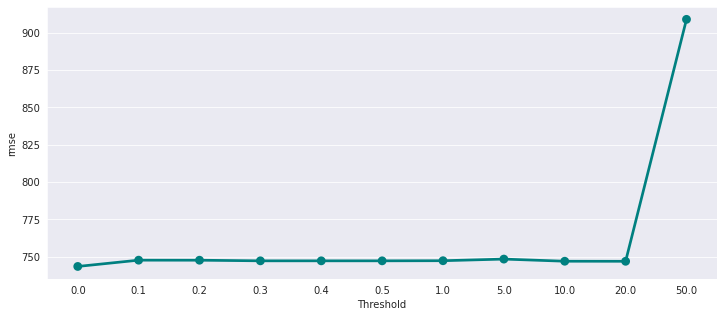

In [257]:
res = pd.DataFrame({'Threshold':thresholds, 'rmse':errors})
plt.figure(figsize = (12, 5))
sns.pointplot(data = res, x = 'Threshold', y = 'rmse', color = 'teal')

###### task: analyse correlation between features
The figure generated below is a correlations heat map. Variable pairs with high negative correlations are shown as the darker regions. The darkest indicates a pairwise correlation of -1. Similarly, variables with high positive correlations are indicated with lighter colors. The lighest being a pairwise correlation of 1. Ignore the light colors in the diagonal as these indicate a variable's correlation with itself, always 1. Our interest in is for example the very bright regions representing the features we computed based on time. Some of these have pairwise correlations as high as 0.9. We certainly do not need all of them. We are also interested in the highly negative corellations we see between variable we computed based on pickup hour and minute such as their interactions and the cosine and sine transformations. The perfomance of a linear model may improve from exclusion of such variables.  

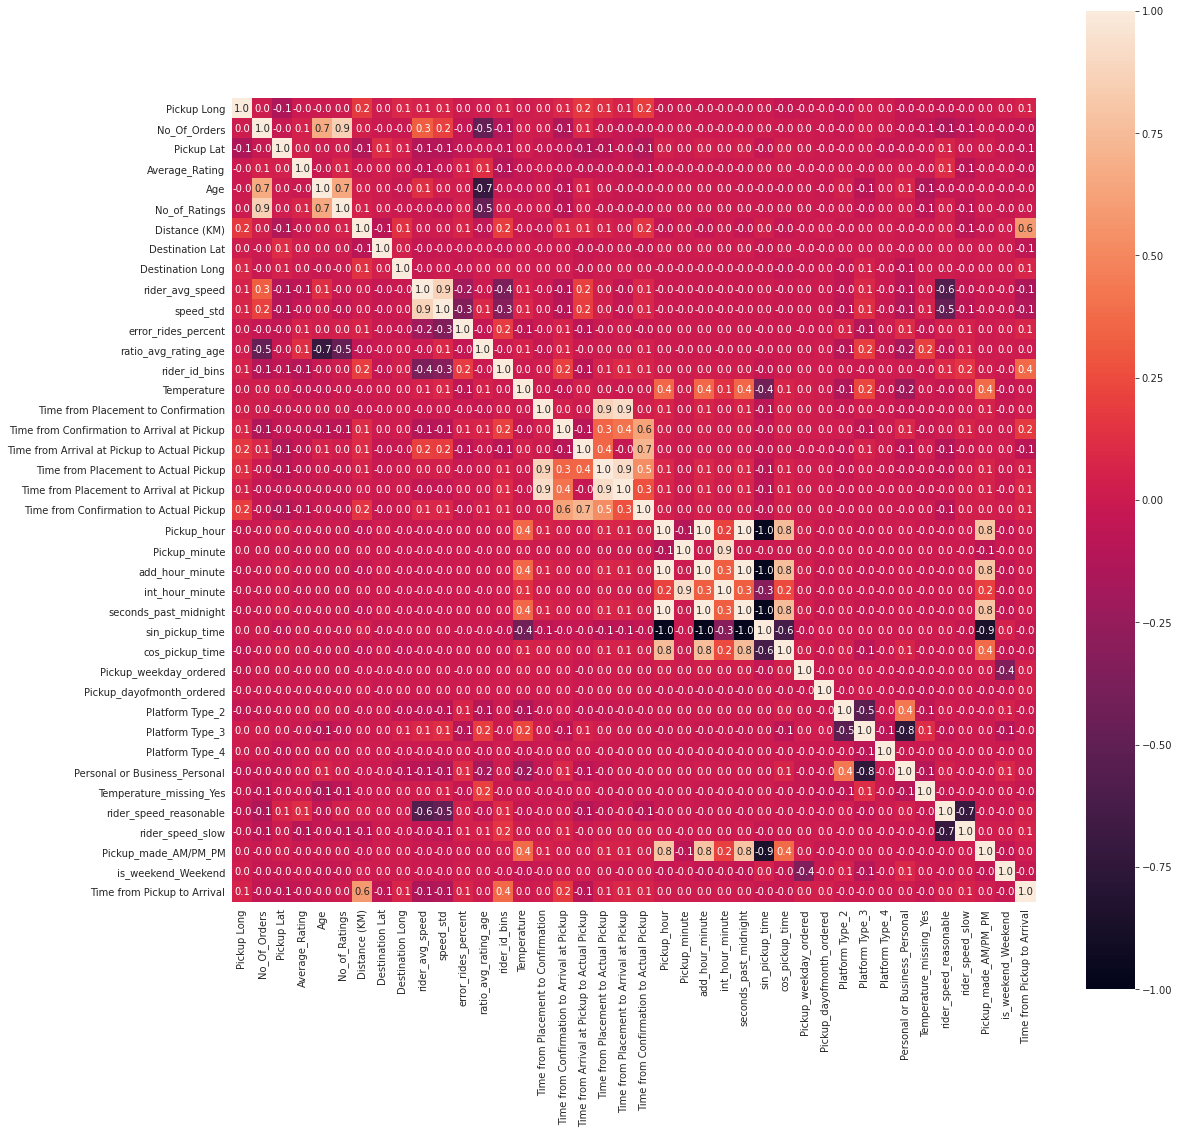

In [258]:
# check for collinearity and multi-collinearity
from statsmodels.graphics.correlation import plot_corr

varz = predictors['Raw + numeric + time transformations']
data = train_data.loc[:, varz]
data = pd.get_dummies(data, drop_first=True)
data['Time from Pickup to Arrival'] = train_data['Time from Pickup to Arrival'] 

fig = plt.figure(figsize=(18, 18));

corr_data = data.corr()
# mask = abs(corr_data) < 0.9
sns.heatmap(corr_data, vmin  = -1, vmax = 1, annot = True, fmt = ".1f", square = True)

As such, below we define a function that takes as input a correlation matrix in the form of a pandas dataframe as well as a correlation threshold value. The function return a list of variables that remain after removing those that have pairwise correlations greater than the threshold value. See below for an illustration.

In [0]:
def findLowCorrelation(corr_data, threshold):
    columns = np.full((corr_data.shape[0],), True, dtype=bool)
    for i in range(corr_data.shape[0]):
        for j in range(i+1, corr_data.shape[0]):
            if corr_data.iloc[i,j] >= threshold:
                if columns[j]:
                    columns[j] = False
    selected_columns = corr_data.columns[columns]
    return selected_columns.to_list()

Applying this function to our correlation matrix and setting a threshold of 0.3, we return a list of variables that meet the criterion. For example, among the 6 variables computed based on time, we retain only 2. 

In [261]:
findLowCorrelation(corr_data, 0.2)

['Pickup Long',
 'No_Of_Orders',
 'Pickup Lat',
 'Average_Rating',
 'Distance (KM)',
 'Destination Lat',
 'Destination Long',
 'error_rides_percent',
 'ratio_avg_rating_age',
 'rider_id_bins',
 'Temperature',
 'Time from Placement to Confirmation',
 'Time from Confirmation to Arrival at Pickup',
 'Pickup_minute',
 'sin_pickup_time',
 'Pickup_weekday_ordered',
 'Pickup_dayofmonth_ordered',
 'Platform Type_2',
 'Platform Type_4',
 'rider_speed_reasonable',
 'rider_speed_slow',
 'is_weekend_Weekend']

Now we want to apply this function and train models on less correlated variables. We do this in a cross validation setting. For each training sample in each forl we apply the correlation filter to get on selected columns. Next we fit a liner regressor on the subset and test on a validation set. The function takes as input a dataframe of predictors, X, a series of the target, y, a correlation threshold value and the number of folds in cross validation. It return the average root mean squared error across all folds.

In [0]:
def evalCorrelation(X, y, threshold, cv):
    cv = KFold(n_splits=cv, shuffle = True, random_state=111)
    RMSE = list()
    for train_index, test_index in cv.split(X):

        X_train = X.loc[train_index, ]
        y_train = y[train_index]
        X_val = X.loc[test_index, ]
        y_val = y[test_index]

        df_corr = X_train.corr()
        columns_to_keep = findLowCorrelation(df_corr, threshold)

        X_train = X_train.loc[:, columns_to_keep]
        X_val = X_val.loc[:, columns_to_keep]

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        RMSE.append(rmse)
    return np.mean(RMSE)

Next we wnat to apply the above defined function. We do this for varying values of the correlation threshold to investigate if there is any particular value that produces the best perfomance. See the cell below. Note that for each threshold we get an output from the above defined function.

In [0]:
RMSE = list()
thresholds = np.arange(0.1, 1.1, 0.1)
for threshold in thresholds:
    rmse = evalCorrelation(X, y, threshold = threshold, cv = 10)
    RMSE.append(rmse)

The best threshold value it turns out is 0.9. It produces a root mean squared error of 742, not too different from the model build on all of the data in the section on Predictive modelling. This is probably because the method drop only 3 of the original features and uses 36 columns of the 40 available.

In [273]:
data = pd.DataFrame({'Correlation Threshold':thresholds, 'RMSE':RMSE})
data['Correlation Threshold'] = data['Correlation Threshold'].round(1)
data[data['RMSE'] == data['RMSE'].min()]

Correlation Threshold        RMSE
8                    0.9  742.752265

In [271]:
print('Model uses:', str(len(findLowCorrelation(corr_data, 0.9))) + ' ' + 'variables and drops:')
list(set(X.columns) - set(findLowCorrelation(corr_data, 0.9)))

Model uses: 36 variables and drops:


['seconds_past_midnight',
 'int_hour_minute',
 'Time from Placement to Arrival at Pickup',
 'add_hour_minute']

Visualising rmse for all tried threshold values we get a figure that displays as below. See that a model that drops variables based on a threshold value of 0.3 produces a rmse that is almost as low as the chosen threshold.

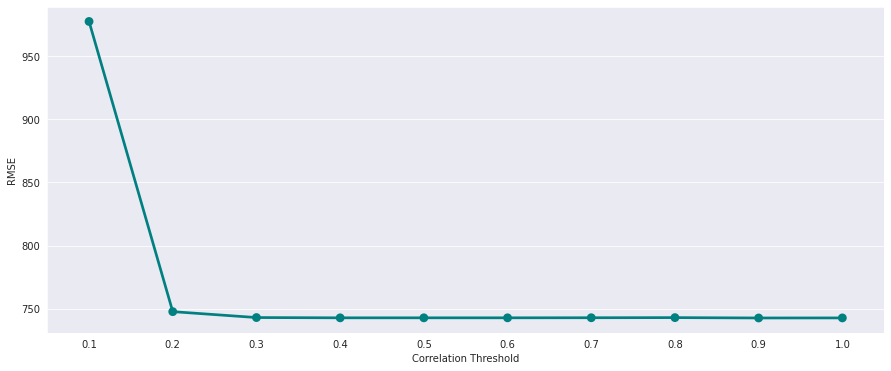

In [0]:
fig = plt.figure(figsize = (15, 6))
sns.pointplot(data = data, x = 'Correlation Threshold', y = 'RMSE', color = 'teal')

This model would have use only 25 of the variables and dropped the list shown below. Note that 9 of the 15 are variables that were computed directly from time columns. We saw this coming. Some of them however are transformation from Distance i.e speed variables.

In [274]:
print('Model uses:', str(len(findLowCorrelation(corr_data, 0.3))) + ' ' + 'variables and drops:')
list(set(X.columns) - set(findLowCorrelation(corr_data, 0.3)))

Model uses: 25 variables and drops:


['Personal or Business_Personal',
 'cos_pickup_time',
 'rider_avg_speed',
 'seconds_past_midnight',
 'Pickup_made_AM/PM_PM',
 'Time from Confirmation to Actual Pickup',
 'Pickup_hour',
 'Age',
 'Time from Placement to Actual Pickup',
 'add_hour_minute',
 'No_of_Ratings',
 'int_hour_minute',
 'Time from Placement to Arrival at Pickup',
 'speed_std']

Seeing this, it is becoming safe to say most of the signal seems to come from only a subset of the variables, not all of them. In the following tasks, we will implement feature selection techniques based on L1 and L2 regularisation.

##### Reguarisation - Improving model perfomance
Regularisation is a general technique in statistical learning that improves the perfomance of learners by making them generalise well to unseen data. One such learner is linear regression. Regularisation in linear models is achieved by fitting linear models that minimise a slightly extended loss function. Here we will use L1 (Lasso) regularisation and L2 (Ridge) regularisation. These work similarly in the sense that they shrink the parameter estimates produced by a simple ols model. We already discussed how they work in the section on predictive modelling. Lasso shrinks estimates all the way to zero, while Ridge does not. Lets go ahead and implement these techniques. The idea is that less important features, either because they lack predictive power or because they have high multicollinearity will be shrunk all the way to zero by Lasso. Ridge will just shrink them to near zero. Import the classes from sklearn.

In [0]:
from sklearn.linear_model import Lasso, Ridge

###### task: implement L1 & L2 Regularisation
The degree to which parameter estimates are shrunk through regularisation can be controlled through manipulation of what is known as a lambda term. High values of lambda for example in a Lasso setting can result in almost all parameters shrunk to zero resulting in a naive model that predict the mean value of the target. Although the same cannot be said of ridge regression, it also has this parameter. The default value of lambda in the classes provided by sklearn is 1. The parameter in the module is alpha. Here we tune this parameter over several values. The general expectation is that an alpha increases, more regularisation is applied and therefore more variable coefficients are shrunk. The best parameter for each model will be evaluated for perfomance on a 10 fold cross validation scheme. The function below takes as input the predictor dataframe, the target series object, a value for alpha and a func argument we use to specify whether we evaluate Lasso or Ridge. The output is a rmse and a dataframe of the coefficients for each variable averaged per fold.

In [0]:
def selector(X, y, cv, alpha, func):
    coefficients = pd.DataFrame()
    rmse = {}
    cv = KFold(n_splits=cv)
    for i, (train_index, test_index) in enumerate(cv.split(X)):

        X_train = X.loc[train_index, ]
        y_train = y[train_index]
        X_val = X.loc[test_index, ]
        y_val = y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

        regressor = func(alpha = alpha)
        regressor.fit(X_train, y_train)

        coefs = pd.DataFrame({'Coef':regressor.coef_}, index = X.columns)
        coefs['FOLD'] = 'Fold_{}'.format(i + 1)
        coefficients = pd.concat([coefficients, coefs])

        y_pred = regressor.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse['Fold_{}'.format(i + 1)] = error
    return rmse, coefficients

Now in the loop below we loop through various values of alpha, ranging between 0 and 10. These are chosen arbitrarily. We also look through a dictionary named models, whose values are the model classes we imported from sklearn. We then implement the function defined above for each combination of model and alpha.

In [0]:
alpha_params = np.linspace(0, 10)
models = dict(Lasso = Lasso, Ridge = Ridge)

results = pd.DataFrame()
coefficients = pd.DataFrame()

for alpha in alpha_params:
    for model, regressor in models.items():
        rmse, coefs = selector(X, y, cv = 10, alpha=alpha, func=regressor)
        perf = pd.DataFrame(rmse, index = [0]).melt(var_name = 'FOLD', value_name = 'rmse')
        perf['Model'] = model
        perf['alpha'] = alpha
        results = pd.concat([results, perf])
        coefs['Model'] = model
        coefs['alpha'] = alpha
        coefficients = pd.concat([coefficients, coefs])

The Lasso fails to converge at the default number of iterations provided by sklearn. But still fits the model with close to best parameters. The results output look as displayed below.

In [281]:
results.groupby(['Model', 'alpha']).mean().reset_index().head()

Model     alpha        rmse
0  Lasso  0.000000  742.773684
1  Lasso  0.204082  742.740258
2  Lasso  0.408163  742.718258
3  Lasso  0.612245  742.694499
4  Lasso  0.816327  742.677597

Getting a visual of how each model's rmse changes with the value of alpha, we see that when there is no regularisation, ridge's perfomance is slightly poor. However, as soon as we start regularisation perfomance improves rapidly, and then quickly tappers off, indicationg that small values of the alpha do just as good a job as high values. Note that the model continues to improve for higher values of alpha, but only buy marginal amounts. Lasso displays almost opposite behaviour to Ridge. The model without regularisation performs well, introducint regularisation improve perfomance, only for low values of alpha. Eventually, high values of alpha result in the model shrinking important variables coefficients to zero and the model's perfomance suffers.

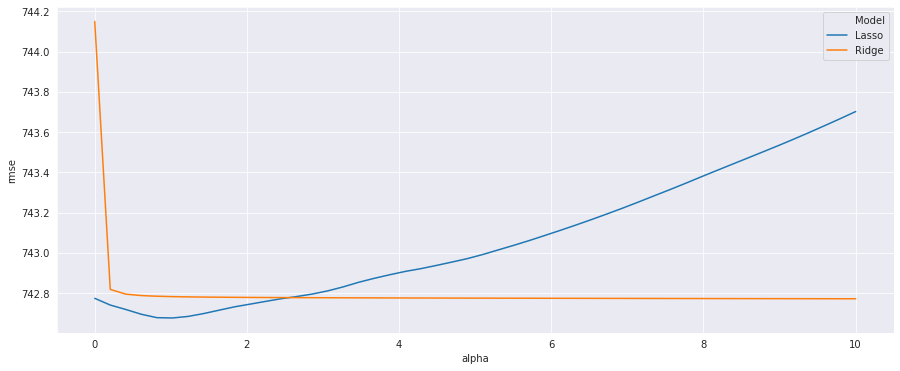

In [283]:
fig = plt.figure(figsize = (15, 6))
sns.lineplot(data = results, x = 'alpha', y = 'rmse', hue = 'Model', ci = None)

The best value of alpha chosen by Lasso is 1.02 and the best value chosen by Ridge is 10. Remember ridge improve marginally afterabout an alpha value of 1.

In [284]:
data = results[results['Model'] == 'Lasso'].groupby('alpha').mean()['rmse']
best_param_lasso = data[data == np.min(data)]
best_param_lasso

alpha
1.020408    742.67606
Name: rmse, dtype: float64

In [285]:
data = results[results['Model'] == 'Ridge'].groupby('alpha').mean()['rmse']
best_param_ridge = data[data == np.min(data)]
best_param_ridge

alpha
10.0    742.771501
Name: rmse, dtype: float64

Now lets look at the variable coefficients estimated by each model. The coefficients output from the model fitting loop looks as displayed below.

In [286]:
coefficients = coefficients.reset_index().groupby(['Model', 'alpha', 'index']).mean().reset_index().rename(columns={'index':'variable'})
coefficients.head()

Model  alpha          variable        Coef
0  Lasso    0.0               Age   19.272748
1  Lasso    0.0    Average_Rating  -11.556739
2  Lasso    0.0   Destination Lat  -13.646749
3  Lasso    0.0  Destination Long  -14.679619
4  Lasso    0.0     Distance (KM)  551.684393

To get a better comparison we'll also get the coefficints that would have been estomated by a linear model. We want to get a sense of the degree of shrinkage. So the following code block will get ols estimates using sklearn's LinearRegression class.

###### task: select the best variables

In [391]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)

regressor = LinearRegression()
regressor.fit(X_scaled, y)
ols_coefs = pd.DataFrame(regressor.coef_, index = X_scaled.columns).reset_index().rename(columns={'index':'variable', 0:'Coef'})
ols_coefs['Coef'] = abs(ols_coefs['Coef'])
ols_coefs['Model'] = 'Linear Regression'
ols_coefs.head()

variable       Coef              Model
0     Pickup Long  34.239704  Linear Regression
1    No_Of_Orders  40.133402  Linear Regression
2      Pickup Lat  10.317511  Linear Regression
3  Average_Rating  11.583515  Linear Regression
4             Age  19.265849  Linear Regression

The following 2 cells get the results of the optimal alpha parametes from the results dataframe and put them in a single dataframe.

In [0]:
all_final_results = pd.DataFrame()
mask1 = coefficients['Model'] == 'Lasso'
alpha_lasso = best_param_lasso.index[0]
mask2 = coefficients['alpha'] == alpha_lasso
data = coefficients[mask1 & mask2][['variable', 'Coef', 'Model']]
data['Coef'] = abs(data['Coef'])
order = data.sort_values('Coef', ascending = False)['variable'].to_list()
all_final_results = pd.concat([all_final_results, data], axis = 0)

In [0]:
mask1 = coefficients['Model'] == 'Ridge'
alpha_ridge = best_param_ridge.index[0]
mask2 = coefficients['alpha'] == alpha_ridge
data = coefficients[mask1 & mask2][['variable', 'Coef', 'Model']]
data['Coef'] = abs(data['Coef'])
all_final_results = pd.concat([all_final_results, data], axis = 0)

The visual we get below shows the coefficients for each of the variables ordered from hidgest to lowest. Note that high negative values indicate the importance of negative relationship between the predictor and the target. Also, the variables (y_axis) are sorted from most important to least important based on the absolute coefficients produced by Lasso.

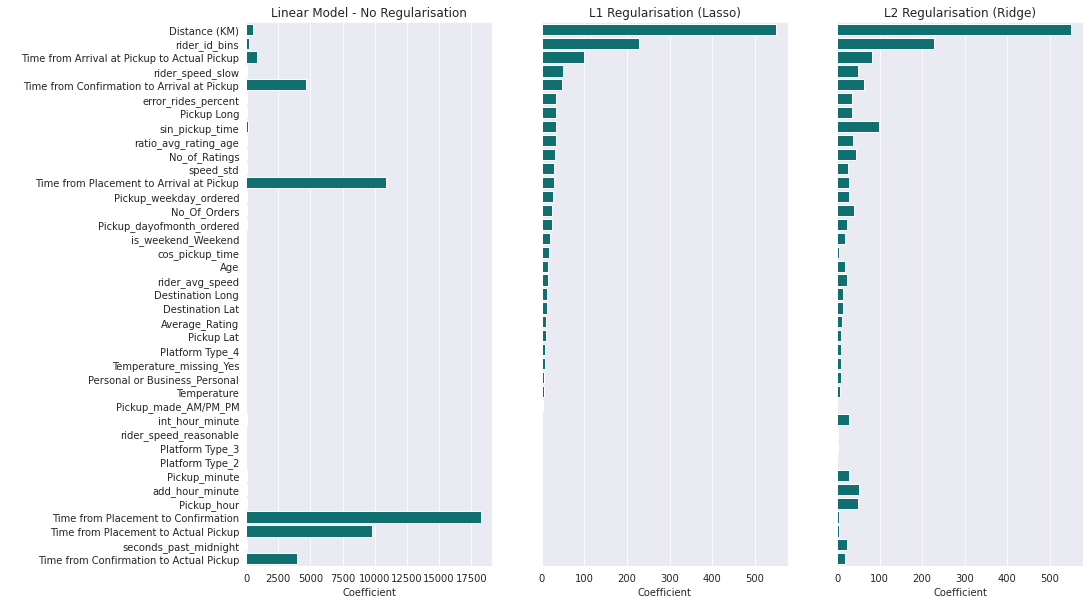

In [394]:
fig, axes = plt.subplots(1, 3, figsize = (15, 10))
gl = sns.barplot(data = ols_coefs, x = 'Coef', y = 'variable', color = 'teal', ax = axes[0], order = order)
gl.set_title('Linear Model - No Regularisation')
gl.set_ylabel(' ')
gl.set_xlabel('Coefficient')
for i, model in enumerate(all_final_results['Model'].unique()):
    data = all_final_results[all_final_results['Model'] == model]
    g = sns.barplot(data = data, x = 'Coef', y = 'variable', color = 'teal', ax = axes[i+1], order = order)
    g.set(yticklabels=[])
    g.set_ylabel(' ')
    g.set_xlabel('Coefficient')
    if model == 'Lasso':
        g.set_title('L1 Regularisation (Lasso)')
    else:
        g.set_title('L2 Regularisation (Ridge)')

The left most panel shows the coefficients estimated by the linear model. The inner most by Lasso and the right most by Ridge. See that the regualrised models agree that the 2 most important variables are Distance and rider ids binned. The non regularised linear model however disagrees. Her most important variable is 'Time from Placement to Confirmation' and is give a coefficient of more than 17000 while Lasso shrinks it to zero and Ridge shrinks it to near zero. Actually all highly ranked variables by linear regression have low rankings after regularisation. See the figure.

Now lets use the results from Lasso to select a final subset of predictors. We will use the following procedure: we fit a linear model with all predictors in the dataset (39). We then get the cross validated predictions made by this model. We will treat these predictions as our models' perfomance. After this, we want to fit other linear models. This time however, we start with one predictor, the most important one as determined by lasso and get its predictions. Now if we calculate the R squared between this single features' prediction and the predictions made by all the features we can get the proportion of the model's perfomance that is explained by this one most important variable. We'll record that and store it. We then fit another model with the 2 most important variable, and another with 3, another with 4 and so on, recordeing the R square between the predictions. Lets go ahead and do this in the following cells.

In [0]:
# get variable sorted by most important based on Lasso coefficients.
data = all_final_results[all_final_results['Model'] == 'Lasso']
variables_sorted = abs(data.set_index('variable')['Coef']).sort_values(ascending = False).index

In [0]:
# get cross validated prediction of a linear model will al predictors
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
regressor = LinearRegression()
predictions = cross_val_predict(regressor, X, y, cv = 10)

In [0]:
# fit multiple models with increasing number of variables and record R_squared between each model's predictions
# with the predictions from the model fitted in the above cell
scores = {}
error_rate = {}
for i in range(1, len(variables_sorted) + 1):
    variables = variables_sorted[0:i]
    number_of_variables = len(variables)
    regressor = LinearRegression()
    rmse = cross_val_score(regressor, X.loc[:, variables], y, cv = 10, scoring = 'neg_root_mean_squared_error')
    err_rate = ((abs(np.mean(rmse)) / np.mean(y)) * 100).round(3)
    error_rate[number_of_variables] = err_rate
    preds = cross_val_predict(regressor, X.loc[:, variables], y, cv = 10)
    r2score = r2_score(predictions, preds)
    scores[number_of_variables] = round(r2score, 3)
    # print(number_of_variables)

In [0]:
# the scores will generally start from the model with 1 variable. Add zero scores for a model with 
# no variables at all
scores[0] = 0
error_rate[0] = 100

In [400]:
# get the errors output from the above operation in a dataframe
errors_data = pd.DataFrame(error_rate, index = [0]).melt().rename(columns = {'variable':'Number of Variables','value':'Error_rate'})
errors_data.head()

Number of Variables  Error_rate
0                    1      51.614
1                    2      48.779
2                    3      48.246
3                    4      48.119
4                    5      47.970

In [401]:
# get the R_square scores from the above operation in a dataframe
r2_data = pd.DataFrame(scores, index = [0]).melt().rename(columns = {'variable':'Number of Variables','value':'Model Variance Explained'})
r2_data['Model Variance Explained'] = r2_data['Model Variance Explained'].mul(100)
r2_data.head()

Number of Variables  Model Variance Explained
0                    1                      77.0
1                    2                      93.1
2                    3                      96.0
3                    4                      96.7
4                    5                      97.5

In [403]:
# bring together the dataframe of errors and that of R_square score together and melt it
data = pd.merge(left = errors_data, right = r2_data, how = 'left', on = 'Number of Variables').sort_values('Number of Variables')
data = pd.melt(data, id_vars = ['Number of Variables'], var_name = 'Metric')
data.head()

Number of Variables      Metric    value
0                    0  Error_rate  100.000
1                    1  Error_rate   51.614
2                    2  Error_rate   48.779
3                    3  Error_rate   48.246
4                    4  Error_rate   48.119

Text(0, 0.5, ' ')

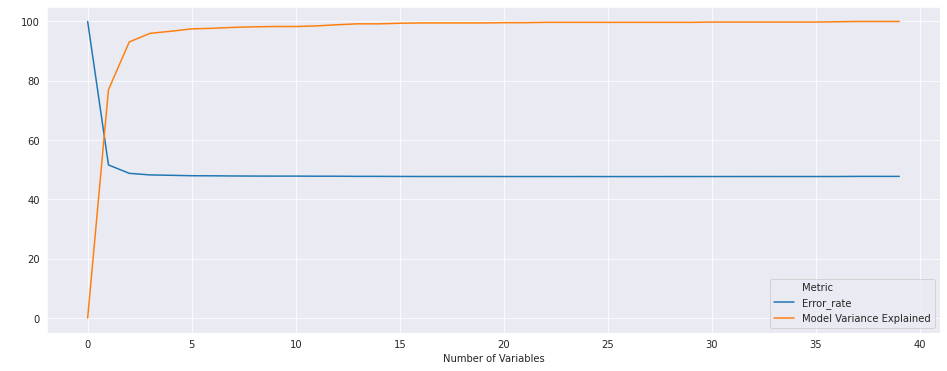

In [404]:
# plot the results
fig = plt.figure(figsize = (16, 6))
sns.lineplot(data = data, x = 'Number of Variables', y = 'value', hue = 'Metric', color = 'teal')
plt.ylabel(' ')

In the visual above, the x axis show the number of predictors. On the y axis you see a value between 0 and 100 indication the proportion of a model with all variables' perfomance that is explained by the number of variables on the x axis. so for example, at x = 5, we have the 5 most important variables by Lasso and by looking at the orange line we see that near 100 percent of that model's predictions or perfomance comes from those first 5 variables. The blue line, error rate is just there to support this point. After the inclusion of the 5 most important variable, there is barely any improvement in the erro rate. The error rate is rmse/mean(target), its like a normalised rmse. From this again we see that by taking between 5 and 10 variables, we can get a model that perfoms just as well as the model with 39 variables.

###### task: select the best model
Below we fit a linear regressor with just 10 variables. Its perfomance compares well with a linear model that has all the variables. Most importantly it is easier to interprate. Its rmse is 744.94.

In [407]:
regressor = LinearRegression()
rmse = cross_val_score(regressor, X.loc[:, variables[:10]], y, cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print('Linear model with on 10 most importante variables RMSE: ', abs(rmse).round(2))

Linear model with on 10 most importante variables RMSE:  744.94


From the section on Predictive modelling we also saw that we had a Tree model (GradientBoostingRegressor) that outperfomred all the models we tried. That model is complex and its results are not easily interpretable. Although its perfomance was better (RMSE:716), the above linear model is not to far from it. Because of simplicity we would like our solution to be the linear model. We can still fit the GBR on the 10 variables selected by Lasso, for interest's sake. See that, it is only about 9 seconds more accurate that a simpler model.

In [372]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators=200)
rmse = cross_val_score(regressor, X.loc[:, variables_sorted[:10]], y, cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print(abs(rmse))

735.5952257672163


Tree model have the advantage that they produce their own importance scores bases of RMSE during the tree building process. Lets get those and take a look. We may get informed about why it perfoms slightly better.

In [373]:
regressor.fit(X.loc[:, variables], y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
GB_importances_data = pd.DataFrame(regressor.feature_importances_, index = variables).rename(columns={0:'Importance'}).reset_index().sort_values('Importance', ascending=False)

In [375]:
GB_importances_data.head()

variable  Importance
0                                  Distance (KM)    0.653164
1                                  rider_id_bins    0.126980
18                               rider_avg_speed    0.043212
2   Time from Arrival at Pickup to Actual Pickup    0.041823
22                                    Pickup Lat    0.021759

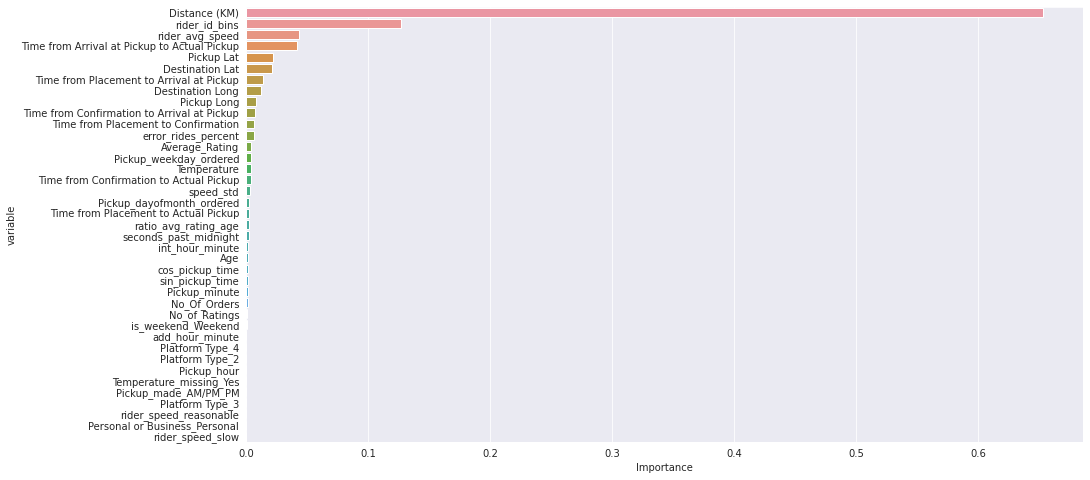

In [376]:
fig = plt.figure(figsize = (15, 8))
sns.barplot(data = GB_importances_data, x = 'Importance', y = 'variable')

It shouldnt be very surprising that its 2 most important variables are Distance and rider ids binned. It seems to include many of the longitude and latitude data in its top 10 whereas the linear model only chose Pickup longitude in that regard. Such differences are probably due to the nature of trees that it can easily decipher non linear patterns, maybe the variables chosen by GBR that were not chosen by the linear model are just non linearly related to the target. But anyhow, our linear model doesn't suffer for it. It is really competetive, regardless.

# Summary of Conclusions

In [0]:
# summarise findings and make recommendations